## Предсказание запаса реактивности на основе изотопных составов топливных зон

In [35]:
# Импоортируем библиотеки
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import LinearSVR, SVR
import tensorflow as tf

In [2]:
# Считываем подготовленный csv
main_df = pd.read_csv('final.csv', sep=',', index_col=0 )

In [3]:
#Посмотрим на кол-во объектов и признаков
main_df.shape

(91, 172802)

Итого 91 различный вариант, помиотрим хватит ли такого кол-ва

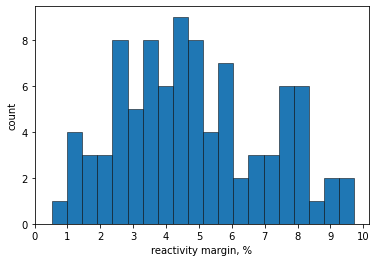

In [214]:
# Построим разброс значений целевой переменной
plt.hist(main_df.reactivity_margin, bins=20, linewidth=0.5, edgecolor="black")
plt.xlabel('reactivity margin, %')
plt.ylabel('count')
plt.xticks(list(range(11)))
plt.show()

В целом явно выпадающих значений нет, большая часть значений лежит от 3 до 5%, что соответствуеют типичному циклу работы реактора

In [215]:
# Поскольку реактивность зависит только от Кэф, удаляем данный столбец
main_df.drop(columns=['Keff'], inplace=True)
target = main_df.pop('reactivity_margin')
# Разделяем данные на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(main_df, target, test_size=0.3, random_state=7)
# Проверяем раззмерности обуч. и тест. наборов
X_train.shape, X_test.shape

((63, 172800), (28, 172800))

## Sklearn модели

In [4]:
# Для начала протестируем самую простую модель наименьших квадратов, а также три модели посложнее, линейную модель,
# которая минимизирует лосс с помощью стохастического градиентного спуска, линейную модель опорных векторов и модель опорных
# векторов с ядерным трюком. Для более сложных моделей будем подбирать оптимальный параметры с помощью HalvingGridSearch
lr = LinearRegression(n_jobs=-1)

sgd = SGDRegressor()

sgd_params = {
    'penalty':['l2', 'elasticnet'],
    'alpha':[0.0001, 0.001, 0.005],
    'l1_ratio':[0.15, 0.25, 0.5, 0.65, 0.75],
    'fit_intercept':[True],
    'tol':[0.0005],
    'max_iter':[50000]
}

lin_svr = LinearSVR()
             
lin_svr_params = {
    'tol':[0.0005],
    'C':[0.1, 0.5, 1, 10],
    'max_iter':[50000]
}

svr = SVR()

svr_params = {
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'tol': [0.0005], 
    'C': np.logspace(-3,2, 6),
    'max_iter': [-1]
}


In [5]:
# Поскольку решается задача регрессии, то для поиска параметров можно ограничиться обычной k-блочной перекрестной проверкой
sss = KFold(n_splits=3, shuffle=True, random_state=7)

In [218]:
%%time 
# Обучаем модели
lr.fit(X_train, y_train)

sgd_search = HalvingGridSearchCV(estimator=sgd, 
                                 param_grid=sgd_params,
                                 scoring='r2',
                                 cv=sss, 
                                 random_state=7,
                                 n_jobs=-1).fit(X_train, y_train)

lin_svr_search = HalvingGridSearchCV(estimator=lin_svr, 
                                     param_grid=lin_svr_params,
                                     scoring='r2',
                                     cv=sss, 
                                     random_state=7,
                                     n_jobs=-1).fit(X_train, y_train)

svr_search = HalvingGridSearchCV(estimator=svr, 
                                 param_grid=svr_params,
                                 scoring='r2',
                                 cv=sss, 
                                 random_state=7,
                                 n_jobs=-1).fit(X_train, y_train)


Wall time: 4min 29s


In [219]:
#Глядя на ошибку обычной линейной модели, можно сделать вывод, что данная модель для решения задачи не подходит
mean_absolute_error(y_test, lr.predict(X_test))

494.363415440665

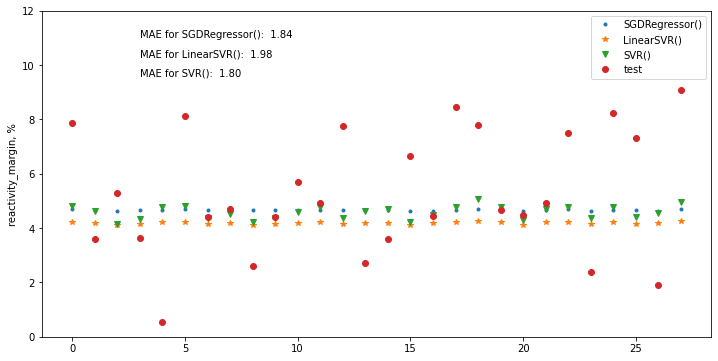

In [220]:
models = [sgd_search, lin_svr_search, svr_search]
markers = ['.', '*', 'v']
fig, ax = plt.subplots(figsize=(12,6))
for model, marker, y_text in zip(models, markers, [11,10.3,9.6]):
    y_pred = model.predict(X_test)
    ax.plot(y_pred, marker, label=(model.estimator))
    ax.text(s=f'MAE for {model.estimator}: {mean_absolute_error(y_test, y_pred): .2f}', x=3, y=y_text)
ax.plot([x for x in range(len(y_test))], y_test, 'o', label='test')
ax.set_ylabel('reactivity_margin, %')
ax.set_ylim(0, 12)
ax.legend()
plt.show()

## Вывод
Регрессионные модели способны предсказывать с довольно большой погрешностью, что может быть связано с влиянием различных ампульных устройств в отражателе, в особоенности ампулы в ячейке 6-4

In [2]:
# в файле final_with_ampules.csv помимо изотопных составов также имеется информация о ампуле в ячейке 6-4, которая
# уменьшает запас реактивности на порядка 2%. Это можно учесть просто вычев или прибавив данное значение, но 
# для начала можно попробовать учесть это простой индекацией наличия данной ампулы.
main_df2 = pd.read_csv('final_with_ampules.csv', sep=',', index_col=0 )

In [3]:
#Посчитаем кол-во вариантов с ампулой и без и соответствующие запасы
main_df2.groupby('ampule').agg({'Keff':'count', 'reactivity_margin':'mean'})

,Keff,reactivity_margin
ampule,,
0,22,4.867830
1,68,4.929305


In [4]:
main_df2.drop(columns=['Keff'], inplace=True)
target2 = main_df2.pop('reactivity_margin')

C:\Users\Anton\AppData\Local\Temp/ipykernel_1660/876083021.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_avg_conc[f'avg_c_in_{num_matr}_to_{num_matr+NUM_ZONES_PER_FE-1}_for_{nuclide}'] = main_df2.filter(items = [f'{nuclide} in mat{num}' for num in range(num_matr, num_matr+NUM_ZONES_PER_FE)], axis=1).apply(axis=1, func=np.mean)


,avg_c_in_15563_to_15922_for_u235,avg_c_in_15923_to_16282_for_u235,avg_c_in_16283_to_16642_for_u235,avg_c_in_16643_to_17002_for_u235,avg_c_in_17003_to_17362_for_u235,avg_c_in_17363_to_17722_for_u235,avg_c_in_17723_to_18082_for_u235,avg_c_in_18083_to_18442_for_u235,avg_c_in_18443_to_18802_for_u235,avg_c_in_18803_to_19162_for_u235,...,avg_c_in_46523_to_46882_for_sm49,avg_c_in_46883_to_47242_for_sm49,avg_c_in_47243_to_47602_for_sm49,avg_c_in_47603_to_47962_for_sm49,avg_c_in_47963_to_48322_for_sm49,avg_c_in_48323_to_48682_for_sm49,avg_c_in_48683_to_49042_for_sm49,avg_c_in_49043_to_49402_for_sm49,avg_c_in_49403_to_49762_for_sm49,avg_c_in_49763_to_50122_for_sm49
0,0.001258,0.001274,0.001283,0.001288,0.001287,0.001279,0.001745,0.001756,0.001763,0.001766,...,3.062928e-07,3.056739e-07,3.075975e-07,3.130251e-07,2.325608e-07,2.320271e-07,2.320205e-07,2.327532e-07,2.343023e-07,2.371966e-07
1,0.001258,0.001274,0.001283,0.001288,0.001287,0.001279,0.001745,0.001756,0.001763,0.001766,...,3.062928e-07,3.056739e-07,3.075975e-07,3.130251e-07,2.325608e-07,2.320271e-07,2.320205e-07,2.327532e-07,2.343023e-07,2.371966e-07
2,0.001258,0.001274,0.001283,0.001288,0.001287,0.001279,0.001745,0.001756,0.001763,0.001766,...,3.062928e-07,3.056739e-07,3.075975e-07,3.130251e-07,2.325608e-07,2.320271e-07,2.320205e-07,2.327532e-07,2.343023e-07,2.371966e-07
3,0.001258,0.001274,0.001283,0.001288,0.001287,0.001279,0.001745,0.001756,0.001763,0.001766,...,3.062928e-07,3.056739e-07,3.075975e-07,3.130251e-07,2.325608e-07,2.320271e-07,2.320205e-07,2.327532e-07,2.343023e-07,2.371966e-07
4,0.001120,0.001135,0.001143,0.001147,0.001144,0.001133,0.001621,0.001634,0.001642,0.001645,...,2.723002e-07,2.719446e-07,2.729689e-07,2.762814e-07,2.044777e-07,2.043944e-07,2.045678e-07,2.049895e-07,2.058990e-07,2.074468e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.001731,0.001722,0.001673,0.001698,0.001716,0.001658,0.001204,0.001213,0.001184,0.001196,...,1.744768e-07,1.783566e-07,1.800168e-07,1.748016e-07,2.180973e-07,2.163685e-07,2.088396e-07,2.135990e-07,2.138828e-07,2.135722e-07
86,0.001715,0.001707,0.001659,0.001683,0.001701,0.001643,0.001193,0.001202,0.001174,0.001185,...,1.161421e-07,1.186566e-07,1.191609e-07,1.144789e-07,1.565044e-07,1.568710e-07,1.521704e-07,1.559188e-07,1.555900e-07,1.537947e-07
87,0.001687,0.001680,0.001633,0.001657,0.001674,0.001617,0.001174,0.001184,0.001156,0.001166,...,1.221652e-07,1.249094e-07,1.258932e-07,1.217462e-07,1.599630e-07,1.594996e-07,1.543420e-07,1.579889e-07,1.578659e-07,1.567750e-07
88,0.001602,0.001598,0.001555,0.001579,0.001594,0.001537,0.001116,0.001126,0.001099,0.001109,...,2.226987e-07,2.278143e-07,2.309709e-07,2.263424e-07,2.657612e-07,2.612477e-07,2.510024e-07,2.562330e-07,2.571179e-07,2.585452e-07


In [5]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(main_df2, target2, test_size=0.2, random_state=7)

In [10]:
%%time
#В качестве первого шага применим аналогичные модели
sgd_search = HalvingGridSearchCV(estimator=sgd, 
                                 param_grid=sgd_params,
                                 scoring='r2',
                                 cv=sss, 
                                 random_state=9,
                                 n_jobs=-1).fit(X_train2, y_train2)

lin_svr_search = HalvingGridSearchCV(estimator=lin_svr, 
                                     param_grid=lin_svr_params,
                                     scoring='r2',
                                     cv=sss, 
                                     random_state=9,
                                     n_jobs=-1).fit(X_train2, y_train2)

svr_search = HalvingGridSearchCV(estimator=svr, 
                                 param_grid=svr_params,
                                 scoring='r2',
                                 cv=sss, 
                                 random_state=9,
                                 n_jobs=-1).fit(X_train2, y_train2)

Wall time: 6min 24s


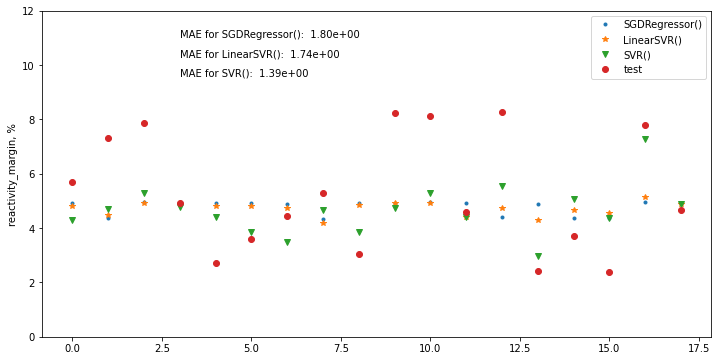

In [11]:
models = [sgd_search, lin_svr_search, svr_search]
markers = ['.', '*', 'v']
fig, ax = plt.subplots(figsize=(12,6))
for model, marker, y_text in zip(models, markers, [11,10.3,9.6]):
    y_pred = model.predict(X_test2)
    ax.plot(y_pred, marker, label=(model.estimator))
    ax.text(s=f'MAE for {model.estimator}: {mean_absolute_error(y_test2, y_pred): .2e}', x=3, y=y_text)
ax.plot([x for x in range(len(y_test2))], y_test2, 'o', label='test')
ax.set_ylabel('reactivity_margin, %')
ax.set_ylim(0, 12)
ax.legend()
plt.show()

## Вывод
Добавив 1 признак наличия ампулы к уже имеющимся **172800**, удалось **снизить** абсолютную ошибку с **2** до **1.4** <div>
**Наилучшей** моделью из рассмотренных оказалась **SVC**, что связано с большой нелинейностью зависимости целевой переменной от признаков

## Библиотека XGBoost + Optuna

In [36]:
# !pip install xgboost
# !pip install optuna
import xgboost as xgb
import optuna

In [9]:
def objective(trial, data=main_df2, label=target2):
    train_x, valid_x, train_y, valid_y = train_test_split(data, label, test_size=0.25)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 2,
        "objective": "reg:squarederror",
        "num_round": trial.suggest_int("num_round", 1000, 4000, step=500),
        # For larger dataset, approximate algorithm (approx) will be chosen.
        # Also it’s recommended to try hist and gpu_hist for higher performance with large dataset.
        "tree_method": "approx",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data. XGBoost would randomly sample half of the training data prior to growing trees
        # and this will prevent overfitting.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 2, 4, step=1)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    rmse = mean_squared_error(valid_y, preds, squared=False)
    return rmse

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=300, timeout=None, n_jobs=3)

print("Number of finished trials: ", len(study.trials))
print(f"Best trial: {study.best_trial}") 

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-07-07 14:56:01,337] A new study created in memory with name: no-name-f73686d6-c19e-45a0-a444-e8ec0e43b58b
C:\Users\Anton\anaconda3\lib\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[I 2022-07-07 14:56:24,870] Trial 0 finished with value: 2.430555282752741 and parameters: {'num_round': 1800, 'booster': 'gblinear', 'lambda': 8.227760886309509e-05, 'alpha': 0.0005691009810988934, 'subsample': 0.49651343391372627, 'colsample_bytree': 0.4376722526734275}. Best is trial 0 with value: 2.430555282752741.
[I 2022-07-07 14:56:36,377] Trial 2 finished with value: 5.236896119942323 and parameters: {'num_round': 1800, 'booster': 'gbtree', 'lambda': 0.043488084432377165, 'alpha': 5.076240052645602e-06, 'subsample': 0.7655432660452626, 'colsample_bytree': 0.9498836492494249, 'max_depth': 2, 'min_child_weight': 3, 'eta': 0

[I 2022-07-07 15:00:21,699] Trial 18 finished with value: 5.390367561014091 and parameters: {'num_round': 1200, 'booster': 'gbtree', 'lambda': 9.967687997076664e-08, 'alpha': 0.06811103086406933, 'subsample': 0.9958571487362718, 'colsample_bytree': 0.5108706472997259, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.0005843056713221172, 'gamma': 2.1581692598993987e-05, 'grow_policy': 'lossguide'}. Best is trial 12 with value: 1.0113901692984892.
[I 2022-07-07 15:00:21,995] Trial 19 finished with value: 4.9187118444559035 and parameters: {'num_round': 1200, 'booster': 'gbtree', 'lambda': 3.3044484485748855e-08, 'alpha': 0.02621618880297237, 'subsample': 0.9676690745966772, 'colsample_bytree': 0.5391917491143224, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.00073317502029619, 'gamma': 2.4762463159503173e-05, 'grow_policy': 'lossguide'}. Best is trial 12 with value: 1.0113901692984892.
[I 2022-07-07 15:00:26,096] Trial 20 finished with value: 5.268041688835375 and parameters: {'num_roun

[I 2022-07-07 15:06:37,595] Trial 35 finished with value: 1.3384715711936834 and parameters: {'num_round': 2000, 'booster': 'dart', 'lambda': 3.146244115275389e-05, 'alpha': 0.0012308000148380633, 'subsample': 0.6126090558827442, 'colsample_bytree': 0.3336802323208302, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.6644770282947552, 'gamma': 0.04585402413811472, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0029788770225999055, 'skip_drop': 1.1544550962501604e-08}. Best is trial 12 with value: 1.0113901692984892.
[I 2022-07-07 15:06:56,167] Trial 36 finished with value: 5.3268839392372485 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 5.634879768358497e-07, 'alpha': 1.3270940492993441e-05, 'subsample': 0.4688011395580942, 'colsample_bytree': 0.22332051432376548, 'max_depth': 4, 'min_child_weight': 10, 'eta': 4.983906419770144e-07, 'gamma': 0.001129720093503864, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'no

[I 2022-07-07 15:09:24,536] Trial 51 finished with value: 2.7229554535689062 and parameters: {'num_round': 1400, 'booster': 'dart', 'lambda': 1.4270712252836913e-08, 'alpha': 0.853230760538693, 'subsample': 0.23945152171561246, 'colsample_bytree': 0.4701140033147886, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.9951707474161858, 'gamma': 1.062450736752566e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00019025177638141438, 'skip_drop': 0.05163349254742995}. Best is trial 47 with value: 0.9131760592735361.
[I 2022-07-07 15:10:09,675] Trial 52 finished with value: 1.0671565974842119 and parameters: {'num_round': 2000, 'booster': 'dart', 'lambda': 1.1737189306985906e-06, 'alpha': 0.015638439698865133, 'subsample': 0.7849548387283576, 'colsample_bytree': 0.40902438412852865, 'max_depth': 4, 'min_child_weight': 7, 'eta': 0.3543336837811939, 'gamma': 0.0048179076939517404, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normaliz

[I 2022-07-07 15:25:28,306] Trial 69 finished with value: 4.337536209157202 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 0.24453017370123636, 'alpha': 0.09352013493016875, 'subsample': 0.8767823291422302, 'colsample_bytree': 0.9987319583120113, 'max_depth': 3, 'min_child_weight': 6, 'eta': 0.020887156573176694, 'gamma': 0.060650834709808185, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.013402420076569265, 'skip_drop': 0.10669168908346881}. Best is trial 47 with value: 0.9131760592735361.
[I 2022-07-07 15:25:28,368] Trial 67 finished with value: 4.938769699985421 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 0.0021958772887458833, 'alpha': 0.2941755343187844, 'subsample': 0.8567824578096948, 'colsample_bytree': 0.99451266460687, 'max_depth': 3, 'min_child_weight': 6, 'eta': 0.014996555320731866, 'gamma': 0.0004352672605138753, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type

[I 2022-07-07 16:36:57,270] Trial 83 finished with value: 1.5785141729367698 and parameters: {'num_round': 1200, 'booster': 'gbtree', 'lambda': 3.124474029746038e-06, 'alpha': 0.0015314525521278215, 'subsample': 0.9953524611504457, 'colsample_bytree': 0.6423257946145022, 'max_depth': 4, 'min_child_weight': 7, 'eta': 0.1068615778609044, 'gamma': 0.0008506055914695749, 'grow_policy': 'lossguide'}. Best is trial 47 with value: 0.9131760592735361.
[I 2022-07-07 16:36:59,442] Trial 82 finished with value: 3.4562903622348764 and parameters: {'num_round': 1200, 'booster': 'gbtree', 'lambda': 7.0988396783169875e-06, 'alpha': 0.0017369197140864243, 'subsample': 0.9722486527914258, 'colsample_bytree': 0.629429403374727, 'max_depth': 4, 'min_child_weight': 7, 'eta': 0.03912074913873038, 'gamma': 0.008976841687640954, 'grow_policy': 'lossguide'}. Best is trial 47 with value: 0.9131760592735361.
[I 2022-07-07 16:36:59,552] Trial 84 finished with value: 2.009422917499417 and parameters: {'num_round'

[I 2022-07-07 17:05:28,557] Trial 99 finished with value: 2.1993361561082274 and parameters: {'num_round': 1400, 'booster': 'gblinear', 'lambda': 2.0603462728121785e-08, 'alpha': 0.16931994429517924, 'subsample': 0.8622841579641364, 'colsample_bytree': 0.5618767320681476}. Best is trial 88 with value: 0.8877407743952134.
[I 2022-07-07 17:05:28,635] Trial 98 finished with value: 1.3947406837501617 and parameters: {'num_round': 1400, 'booster': 'gblinear', 'lambda': 4.6728464159812754e-07, 'alpha': 3.139289403673577e-06, 'subsample': 0.8656294875629816, 'colsample_bytree': 0.5535651471185415}. Best is trial 88 with value: 0.8877407743952134.
[I 2022-07-07 17:07:25,541] Trial 102 finished with value: 3.393345311944049 and parameters: {'num_round': 2000, 'booster': 'dart', 'lambda': 6.393780020497667e-07, 'alpha': 3.985650167612618e-08, 'subsample': 0.7740739661592447, 'colsample_bytree': 0.663655078103167, 'max_depth': 4, 'min_child_weight': 7, 'eta': 0.05063542685911479, 'gamma': 0.04111

[I 2022-07-07 17:11:10,220] Trial 114 finished with value: 1.3160485491357572 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 5.4592698581514695e-08, 'alpha': 0.024267542438143063, 'subsample': 0.6015700578991919, 'colsample_bytree': 0.24299988414930815, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.6005672229746578, 'gamma': 0.031277972326379654, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.10300946490748085, 'skip_drop': 0.5447220583184671}. Best is trial 106 with value: 0.7729210244544766.
[I 2022-07-07 17:11:10,938] Trial 112 finished with value: 1.0780924470980557 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 5.4281969083636526e-08, 'alpha': 0.021163418583992795, 'subsample': 0.6349590178198317, 'colsample_bytree': 0.391251761659751, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.6725476875766118, 'gamma': 0.0005575373806224553, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normaliz

[I 2022-07-07 17:15:17,406] Trial 128 finished with value: 2.5155980169761896 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 8.95455146943706e-07, 'alpha': 0.23026912441752817, 'subsample': 0.7325719731281635, 'colsample_bytree': 0.36263841119041373, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.07134232671614706, 'gamma': 0.004040671022571215, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0001225733218382395, 'skip_drop': 0.01910386017241191}. Best is trial 106 with value: 0.7729210244544766.
[I 2022-07-07 17:15:19,702] Trial 130 finished with value: 1.470190229519847 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 1.1743408054876079e-06, 'alpha': 0.03454210446299013, 'subsample': 0.5413430091298302, 'colsample_bytree': 0.35629328887667316, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.18324379108817532, 'gamma': 0.1567599566621204, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize

[I 2022-07-07 17:22:32,061] Trial 145 finished with value: 1.1698020504740934 and parameters: {'num_round': 2000, 'booster': 'dart', 'lambda': 3.6158138168644865e-07, 'alpha': 0.0170718001405816, 'subsample': 0.8964760958789589, 'colsample_bytree': 0.288392435280711, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.8810792232434103, 'gamma': 0.012289905850100778, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0031748839768481283, 'skip_drop': 0.042751897992318974}. Best is trial 106 with value: 0.7729210244544766.
[I 2022-07-07 17:22:32,108] Trial 143 finished with value: 1.098502758191897 and parameters: {'num_round': 2000, 'booster': 'dart', 'lambda': 4.02294602661843e-07, 'alpha': 0.01888127654131026, 'subsample': 0.895578704858783, 'colsample_bytree': 0.2531820699806269, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.9513426058646318, 'gamma': 0.011409680983737626, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_typ

[I 2022-07-07 17:26:02,869] Trial 159 finished with value: 2.048116957147524 and parameters: {'num_round': 1800, 'booster': 'gblinear', 'lambda': 9.13268574273984e-08, 'alpha': 0.028987539736236998, 'subsample': 0.707720479393189, 'colsample_bytree': 0.37051137024658637}. Best is trial 106 with value: 0.7729210244544766.
[I 2022-07-07 17:26:04,866] Trial 160 finished with value: 1.860264137527366 and parameters: {'num_round': 1800, 'booster': 'gblinear', 'lambda': 3.928619566890204e-08, 'alpha': 0.02949847997993717, 'subsample': 0.7037049362090005, 'colsample_bytree': 0.40886628773248435}. Best is trial 106 with value: 0.7729210244544766.
[I 2022-07-07 17:26:09,631] Trial 158 finished with value: 0.9473709440505679 and parameters: {'num_round': 1800, 'booster': 'dart', 'lambda': 2.940363680967826e-07, 'alpha': 0.02752516867990664, 'subsample': 0.851698707233464, 'colsample_bytree': 0.3748799020165568, 'max_depth': 2, 'min_child_weight': 10, 'eta': 0.6984984988185665, 'gamma': 0.0153293

[I 2022-07-07 17:28:46,634] Trial 173 finished with value: 0.8965075692077129 and parameters: {'num_round': 2000, 'booster': 'dart', 'lambda': 1.1797143300861065e-07, 'alpha': 0.03309996897703381, 'subsample': 0.8742891315484451, 'colsample_bytree': 0.37857157903171434, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.654243614700289, 'gamma': 0.012960914614934609, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.08844290281796843, 'skip_drop': 0.9444894725473495}. Best is trial 106 with value: 0.7729210244544766.
[I 2022-07-07 17:29:00,119] Trial 175 finished with value: 1.3435422543552495 and parameters: {'num_round': 2000, 'booster': 'dart', 'lambda': 1.3485283577832868e-07, 'alpha': 0.03549020956458979, 'subsample': 0.6621119015274146, 'colsample_bytree': 0.3564381288502467, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.45529561632919896, 'gamma': 0.10390373390133761, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_t

In [52]:
#Рассмотрение концентрации в каждой зоне объема весьма затратно, поэтому создидим новый df с усредненными по твэлам концентрациями
NUM_ZONES_PER_FE = 360
df_avg_conc = pd.DataFrame()
for nuclide in ['u235', 'u238', 'pu39', 'xe35', 'sm49']:
    for num_matr in range(15563, 50123, NUM_ZONES_PER_FE):
        df_avg_conc[f'avg_c_in_{num_matr}_to_{num_matr+NUM_ZONES_PER_FE-1}_for_{nuclide}'] = main_df2.filter(items = [f'{nuclide} in mat{num}' for num in range(num_matr, num_matr+NUM_ZONES_PER_FE)], axis=1).apply(axis=1, func=np.mean)
df_avg_conc['ampule'] = main_df2.ampule
df_avg_conc.sample(5)

C:\Users\Anton\AppData\Local\Temp/ipykernel_1660/2670308527.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_avg_conc[f'avg_c_in_{num_matr}_to_{num_matr+NUM_ZONES_PER_FE-1}_for_{nuclide}'] = main_df2.filter(items = [f'{nuclide} in mat{num}' for num in range(num_matr, num_matr+NUM_ZONES_PER_FE)], axis=1).apply(axis=1, func=np.mean)
C:\Users\Anton\AppData\Local\Temp/ipykernel_1660/2670308527.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_avg_conc['ampule'] = main_df2.ampule


,avg_c_in_15563_to_15922_for_u235,avg_c_in_15923_to_16282_for_u235,avg_c_in_16283_to_16642_for_u235,avg_c_in_16643_to_17002_for_u235,avg_c_in_17003_to_17362_for_u235,avg_c_in_17363_to_17722_for_u235,avg_c_in_17723_to_18082_for_u235,avg_c_in_18083_to_18442_for_u235,avg_c_in_18443_to_18802_for_u235,avg_c_in_18803_to_19162_for_u235,...,avg_c_in_46883_to_47242_for_sm49,avg_c_in_47243_to_47602_for_sm49,avg_c_in_47603_to_47962_for_sm49,avg_c_in_47963_to_48322_for_sm49,avg_c_in_48323_to_48682_for_sm49,avg_c_in_48683_to_49042_for_sm49,avg_c_in_49043_to_49402_for_sm49,avg_c_in_49403_to_49762_for_sm49,avg_c_in_49763_to_50122_for_sm49,ampule
14,0.001305,0.001330,0.001344,0.001350,0.001346,0.001328,0.001201,0.001212,0.001215,0.001210,...,1.688385e-07,1.709734e-07,1.628384e-07,1.463107e-07,1.470543e-07,1.474290e-07,1.473954e-07,1.471001e-07,1.464951e-07,1
72,0.001739,0.001805,0.001772,0.001811,0.001763,0.001742,0.001124,0.001116,0.001103,0.001123,...,1.838311e-07,1.864082e-07,1.833515e-07,1.671817e-07,1.663446e-07,1.623331e-07,1.647999e-07,1.667294e-07,1.624078e-07,1
56,0.001927,0.001990,0.001948,0.001989,0.001938,0.001921,0.001102,0.001102,0.001086,0.001085,...,2.508382e-07,2.523008e-07,2.479736e-07,3.010183e-07,2.939193e-07,2.840746e-07,2.874756e-07,2.923675e-07,2.899926e-07,1
40,0.001406,0.001399,0.001374,0.001399,0.001409,0.001353,0.001358,0.001341,0.001281,0.001305,...,2.217732e-07,2.225441e-07,2.183250e-07,1.232251e-08,1.152952e-08,1.088173e-08,1.088369e-08,1.111445e-08,1.132662e-08,0
38,0.001488,0.001479,0.001451,0.001478,0.001489,0.001432,0.001437,0.001417,0.001353,0.001379,...,3.387928e-07,3.410156e-07,3.386492e-07,2.458252e-07,2.477538e-07,2.492566e-07,2.504016e-07,2.512250e-07,2.518468e-07,0


In [54]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(df_avg_conc, target2, test_size=0.2, random_state=7)

In [56]:
def objective(trial, data=X_train3, label=y_train3):
    train_x, valid_x, train_y, valid_y = train_test_split(data, label, test_size=0.25)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 2,
        "objective": "reg:squarederror",
        "num_round": trial.suggest_int("num_round", 5000, 30000, step=5000),
        # For larger dataset, approximate algorithm (approx) will be chosen.
        # Also it’s recommended to try hist and gpu_hist for higher performance with large dataset.
        "tree_method": trial.suggest_categorical("tree_method",["approx", "hist"]),
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 100.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 100.0, log=True),
        # sampling ratio for training data. XGBoost would randomly sample half of the training data prior to growing trees
        # and this will prevent overfitting.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 2, 20, step=1)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 10.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 10.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    rmse = mean_squared_error(valid_y, preds, squared=False)
    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=3000, timeout=None, n_jobs=3)

print("Number of finished trials: ", len(study.trials))
trial=study.best_trial
print(f"Best trial: {trial}") 

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-07-12 11:27:15,742] A new study created in memory with name: no-name-5af613c6-bae9-4ebd-a55e-14e0568af8fe
C:\Users\Anton\anaconda3\lib\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[I 2022-07-12 11:27:15,905] Trial 0 finished with value: 2.2121416714781836 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gblinear', 'lambda': 0.04390870089391053, 'alpha': 0.002099701156015345, 'subsample': 0.40979076462665553, 'colsample_bytree': 0.5452374688160542}. Best is trial 0 with value: 2.2121416714781836.
[I 2022-07-12 11:27:15,910] Trial 1 finished with value: 2.3147940958232525 and parameters: {'num_round': 5000, 'tree_method': 'approx', 'booster': 'gblinear', 'lambda': 0.054400761379098196, 'alpha': 14.401861509485752, 'subsample': 0.9180741288659093, 'colsample_bytree': 0.27826221729978057

[I 2022-07-12 11:27:16,660] Trial 15 finished with value: 653474179.1906933 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 2.3200684805421994, 'alpha': 35.76487343652881, 'subsample': 0.7239445122920845, 'colsample_bytree': 0.6327636679127611, 'max_depth': 20, 'min_child_weight': 7, 'eta': 8.180294677757372, 'gamma': 2.6090434268644136e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0003081916022275679, 'skip_drop': 0.5376574360244206}. Best is trial 4 with value: 1.5069083441037974.
[I 2022-07-12 11:27:16,771] Trial 16 finished with value: 5.0896169869809995 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 4.792314480239125, 'alpha': 45.14314073484691, 'subsample': 0.9465732275473111, 'colsample_bytree': 0.6181438975964464, 'max_depth': 17, 'min_child_weight': 7, 'eta': 0.004825768493329084, 'gamma': 1.5242150202172037e-08, 'grow_policy': 'depthwise

[I 2022-07-12 11:27:17,699] Trial 31 finished with value: 1.7670007364512743 and parameters: {'num_round': 15000, 'tree_method': 'hist', 'booster': 'gblinear', 'lambda': 2.754439075696846e-06, 'alpha': 5.8897131084231105e-05, 'subsample': 0.4393145560473148, 'colsample_bytree': 0.537519773550964}. Best is trial 24 with value: 1.1247424026658837.
[I 2022-07-12 11:27:17,727] Trial 32 finished with value: 2.1504305076900305 and parameters: {'num_round': 15000, 'tree_method': 'hist', 'booster': 'gblinear', 'lambda': 1.6913789893572981e-06, 'alpha': 3.582192442419516e-05, 'subsample': 0.4350407249685209, 'colsample_bytree': 0.8388088750896354}. Best is trial 24 with value: 1.1247424026658837.
[I 2022-07-12 11:27:17,821] Trial 33 finished with value: 2.230153531811102 and parameters: {'num_round': 20000, 'tree_method': 'hist', 'booster': 'gblinear', 'lambda': 1.7673342579729686e-06, 'alpha': 4.3637848179436404e-05, 'subsample': 0.8246973708300087, 'colsample_bytree': 0.5199778149941618}. Bes

[I 2022-07-12 11:27:18,815] Trial 49 finished with value: 3.244712683480279 and parameters: {'num_round': 20000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 7.88020785457316e-07, 'alpha': 0.0003227974982212362, 'subsample': 0.37623656428998414, 'colsample_bytree': 0.9605254381647633, 'max_depth': 6, 'min_child_weight': 3, 'eta': 0.04899130973880723, 'gamma': 0.00024109571044032862, 'grow_policy': 'lossguide'}. Best is trial 24 with value: 1.1247424026658837.
[I 2022-07-12 11:27:18,924] Trial 50 finished with value: 4.242949365802434 and parameters: {'num_round': 15000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 1.1549954256075334e-08, 'alpha': 2.1658521088424846e-05, 'subsample': 0.35510483532526305, 'colsample_bytree': 0.9942610608946435, 'max_depth': 6, 'min_child_weight': 3, 'eta': 0.011075387674750638, 'gamma': 4.467926360542281e-06, 'grow_policy': 'depthwise'}. Best is trial 24 with value: 1.1247424026658837.
[I 2022-07-12 11:27:18,941] Trial 51 finished wit

[I 2022-07-12 11:27:20,002] Trial 67 finished with value: 775474.4952193059 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 5.379844066539909e-08, 'alpha': 1.3958610329227432e-06, 'subsample': 0.7653409177530155, 'colsample_bytree': 0.9010768972220967, 'max_depth': 13, 'min_child_weight': 5, 'eta': 4.337040979565591, 'gamma': 0.00040895711774444657, 'grow_policy': 'lossguide'}. Best is trial 66 with value: 0.9912143239653713.
[I 2022-07-12 11:27:20,138] Trial 68 finished with value: 988148.3868055962 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 5.901054754740861e-08, 'alpha': 3.1230142672774635e-07, 'subsample': 0.6121374222344919, 'colsample_bytree': 0.8860587276255529, 'max_depth': 6, 'min_child_weight': 4, 'eta': 4.453175667559576, 'gamma': 9.568568919085838e-07, 'grow_policy': 'depthwise'}. Best is trial 66 with value: 0.9912143239653713.
[I 2022-07-12 11:27:20,217] Trial 69 finished with v

[I 2022-07-12 11:27:21,224] Trial 84 finished with value: 1.3213417385686395 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.3436137450500172e-06, 'alpha': 2.9870336887390563e-05, 'subsample': 0.8953339202703778, 'colsample_bytree': 0.8509727092050074, 'max_depth': 2, 'min_child_weight': 7, 'eta': 0.5094642668605937, 'gamma': 1.3554500871679561e-06, 'grow_policy': 'lossguide'}. Best is trial 66 with value: 0.9912143239653713.
[I 2022-07-12 11:27:21,259] Trial 85 finished with value: 2.0031803015021956 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.017504231513904e-06, 'alpha': 2.7807812174186635e-05, 'subsample': 0.8752906958495399, 'colsample_bytree': 0.75929603277001, 'max_depth': 2, 'min_child_weight': 7, 'eta': 1.4200909267048143, 'gamma': 1.7271867549569873e-06, 'grow_policy': 'lossguide'}. Best is trial 66 with value: 0.9912143239653713.
[I 2022-07-12 11:27:21,294] Trial 86 finished wit

[I 2022-07-12 11:27:22,330] Trial 101 finished with value: 2.3937095482365787 and parameters: {'num_round': 5000, 'tree_method': 'approx', 'booster': 'gblinear', 'lambda': 1.5774558685358104e-07, 'alpha': 5.693107603375273e-06, 'subsample': 0.574420938441295, 'colsample_bytree': 0.9755816525720031}. Best is trial 66 with value: 0.9912143239653713.
[I 2022-07-12 11:27:22,365] Trial 102 finished with value: 2.1686759174633767 and parameters: {'num_round': 20000, 'tree_method': 'approx', 'booster': 'gblinear', 'lambda': 5.932385494754785e-07, 'alpha': 4.312907736133626e-07, 'subsample': 0.5795523101811344, 'colsample_bytree': 0.6377222467565079}. Best is trial 66 with value: 0.9912143239653713.
[I 2022-07-12 11:27:22,466] Trial 103 finished with value: 0.986191212206165 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.416881671977223e-08, 'alpha': 5.242318949624042e-07, 'subsample': 0.5149124588184019, 'colsample_bytree': 0.5613966322054803, '

[I 2022-07-12 11:27:23,574] Trial 119 finished with value: 1.2635501265426103 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.1894949282691969e-07, 'alpha': 0.010520536451822042, 'subsample': 0.43819183101386205, 'colsample_bytree': 0.4845009901307341, 'max_depth': 11, 'min_child_weight': 5, 'eta': 0.2429222386516321, 'gamma': 0.0005857083298375091, 'grow_policy': 'lossguide'}. Best is trial 103 with value: 0.986191212206165.
[I 2022-07-12 11:27:23,736] Trial 121 finished with value: 5.049336502753516 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 1.6698241540249703e-08, 'alpha': 0.1313602378222116, 'subsample': 0.39267614760562725, 'colsample_bytree': 0.576998664006694, 'max_depth': 10, 'min_child_weight': 4, 'eta': 9.525019247739329e-08, 'gamma': 3.336230934664249e-05, 'grow_policy': 'lossguide'}. Best is trial 103 with value: 0.986191212206165.
[I 2022-07-12 11:27:23,772] Trial 120 finished wi

[I 2022-07-12 11:27:25,020] Trial 136 finished with value: 4.035026272781388 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.8204783399775978e-07, 'alpha': 0.024509371655264914, 'subsample': 0.5315234750170557, 'colsample_bytree': 0.6461085591748391, 'max_depth': 12, 'min_child_weight': 6, 'eta': 1.3735813308150475, 'gamma': 0.011222074576443858, 'grow_policy': 'lossguide'}. Best is trial 103 with value: 0.986191212206165.
[I 2022-07-12 11:27:25,113] Trial 137 finished with value: 1.1866938154297306 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.6411691601982886e-07, 'alpha': 0.020582896215544155, 'subsample': 0.5468840246331637, 'colsample_bytree': 0.6160806484844521, 'max_depth': 11, 'min_child_weight': 9, 'eta': 0.4381450388745197, 'gamma': 0.012205355995825295, 'grow_policy': 'lossguide'}. Best is trial 103 with value: 0.986191212206165.
[I 2022-07-12 11:27:25,198] Trial 138 finished with

[I 2022-07-12 11:27:26,315] Trial 153 finished with value: 0.7982433410898686 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 9.953490577902702e-08, 'alpha': 0.02478551323930366, 'subsample': 0.5588525958873993, 'colsample_bytree': 0.6325544761407588, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.38156409533416474, 'gamma': 0.014345857885899899, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:26,373] Trial 154 finished with value: 1.089778628420582 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 5.2331240724631833e-08, 'alpha': 0.024522292754899668, 'subsample': 0.5577388457663836, 'colsample_bytree': 0.6050808208877172, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.4026413475189894, 'gamma': 0.016249657305032715, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:26,433] Trial 155 finished with 

[I 2022-07-12 11:27:27,553] Trial 170 finished with value: 1.441159385646576 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.0633910586062284e-07, 'alpha': 0.006266331095088388, 'subsample': 0.6031122113170628, 'colsample_bytree': 0.6728494395345558, 'max_depth': 6, 'min_child_weight': 10, 'eta': 0.9050271139866466, 'gamma': 3.948872509853694, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:27,606] Trial 171 finished with value: 1.2594185641422133 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.527784626748684e-08, 'alpha': 0.23200179284382236, 'subsample': 0.6090504402918641, 'colsample_bytree': 0.6220239133530023, 'max_depth': 6, 'min_child_weight': 10, 'eta': 0.7592558340382926, 'gamma': 2.1421951296151547e-06, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:27,769] Trial 172 finished with 

[I 2022-07-12 11:27:28,922] Trial 187 finished with value: 1.3073463824199931 and parameters: {'num_round': 5000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.732233227477002e-08, 'alpha': 0.3021789876173389, 'subsample': 0.7204892073633931, 'colsample_bytree': 0.6369519898288437, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.29955196077197443, 'gamma': 1.912568694165314e-06, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:28,960] Trial 188 finished with value: 1.3525354065495367 and parameters: {'num_round': 5000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.244334468922407e-08, 'alpha': 3.37986771243462e-05, 'subsample': 0.6468581604937232, 'colsample_bytree': 0.6383405872429212, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.3521475619896717, 'gamma': 6.484691833477187e-06, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:29,021] Trial 189 finished with v

[I 2022-07-12 11:27:30,154] Trial 204 finished with value: 1.4241405958278028 and parameters: {'num_round': 5000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.0724948245683293e-07, 'alpha': 1.1981847546480075e-07, 'subsample': 0.5648168793313528, 'colsample_bytree': 0.7179557164984179, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.3138100132034289, 'gamma': 5.570721428396975e-07, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:30,314] Trial 205 finished with value: 1.485391368757923 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.693013330893016e-07, 'alpha': 3.148610089840942e-08, 'subsample': 0.565297578319891, 'colsample_bytree': 0.7235490829628293, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.7089896752159235, 'gamma': 1.0285416840028424e-06, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:30,392] Trial 207 finished w

[I 2022-07-12 11:27:31,569] Trial 222 finished with value: 1.3841987786567265 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.006656528251121736, 'alpha': 1.4912914193389575e-07, 'subsample': 0.5804991948450878, 'colsample_bytree': 0.6678862244158668, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.4911614103467401, 'gamma': 0.007764218938303346, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:31,618] Trial 223 finished with value: 1.2735800410848481 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.5592887812000826e-08, 'alpha': 8.504288871637966e-08, 'subsample': 0.583987763377128, 'colsample_bytree': 0.6651439017778806, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.4246386348448758, 'gamma': 0.008823156762849995, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:31,738] Trial 224 finished wit

[I 2022-07-12 11:27:32,897] Trial 239 finished with value: 1.7009921505584513 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.082713258570608e-08, 'alpha': 3.6740830170297505e-07, 'subsample': 0.713920621578498, 'colsample_bytree': 0.7894297659838336, 'max_depth': 8, 'min_child_weight': 9, 'eta': 0.15128825655153125, 'gamma': 5.413301811796984e-06, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:32,994] Trial 240 finished with value: 1.6927421005113539 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.125262498836197e-08, 'alpha': 2.0477877033949215e-07, 'subsample': 0.7030838134110698, 'colsample_bytree': 0.7988044003945953, 'max_depth': 8, 'min_child_weight': 9, 'eta': 0.927170694187232, 'gamma': 9.500538005308702e-08, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:33,097] Trial 241 finished 

[I 2022-07-12 11:27:34,325] Trial 255 finished with value: 1.561381111777427 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 5.384262897121308e-06, 'alpha': 3.6290359933656603e-07, 'subsample': 0.6638495828403234, 'colsample_bytree': 0.8389300490098021, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.5511585330221112, 'gamma': 1.2595407484264972e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 3.925150409964637e-07, 'skip_drop': 8.593999755825885e-06}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:34,472] Trial 256 finished with value: 1.1629308283690911 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 5.069308395423933e-05, 'alpha': 4.9564063644202e-07, 'subsample': 0.6663671811069961, 'colsample_bytree': 0.7798607080765078, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.2829857263724772, 'gamma': 1.3506917616871094e-05, 'grow

[I 2022-07-12 11:27:35,753] Trial 270 finished with value: 1.7377044244961082 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.5762780193653387e-08, 'alpha': 0.0007198867453769787, 'subsample': 0.5479129824521218, 'colsample_bytree': 0.8839743866150964, 'max_depth': 6, 'min_child_weight': 5, 'eta': 0.7137168748020387, 'gamma': 5.832260232098223e-06, 'grow_policy': 'depthwise'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:35,823] Trial 271 finished with value: 1.6380461436236375 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.162630090674887e-05, 'alpha': 7.448182967665001e-05, 'subsample': 0.6356159806406183, 'colsample_bytree': 0.5705460157617831, 'max_depth': 6, 'min_child_weight': 7, 'eta': 0.693291613949159, 'gamma': 2.516524193984506e-05, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:35,868] Trial 272 finished w

[I 2022-07-12 11:27:37,162] Trial 287 finished with value: 4.3594835815733415 and parameters: {'num_round': 5000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 9.440516113819143e-08, 'alpha': 6.928219650959796e-05, 'subsample': 0.5551760877236055, 'colsample_bytree': 0.8852574441530353, 'max_depth': 10, 'min_child_weight': 5, 'eta': 2.6945359870708907e-07, 'gamma': 0.050386911664201076, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:37,233] Trial 288 finished with value: 1.9604621033123362 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 9.379569912152249e-08, 'alpha': 6.638366348785597e-05, 'subsample': 0.5406819720973653, 'colsample_bytree': 0.6699846676286205, 'max_depth': 6, 'min_child_weight': 5, 'eta': 0.6799559411629326, 'gamma': 1.4640970939227508e-08, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:37,333] Trial 289 finish

[I 2022-07-12 11:27:38,527] Trial 303 finished with value: 0.9662637367062665 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.2362439093146832e-07, 'alpha': 0.012511111530501183, 'subsample': 0.5067210523833205, 'colsample_bytree': 0.2362721990740892, 'max_depth': 8, 'min_child_weight': 9, 'eta': 0.3498778051692435, 'gamma': 4.7898848751938765e-06, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:38,630] Trial 304 finished with value: 1.0514932188463941 and parameters: {'num_round': 5000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.0540564008824228e-07, 'alpha': 0.009952358905156961, 'subsample': 0.5938585351620957, 'colsample_bytree': 0.6332436066258589, 'max_depth': 8, 'min_child_weight': 9, 'eta': 0.4095281610448615, 'gamma': 1.018617464645177e-08, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:38,772] Trial 305 finished w

[I 2022-07-12 11:27:40,010] Trial 321 finished with value: 1.135423232744038 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 7.977397063677064e-08, 'alpha': 0.030969039350736947, 'subsample': 0.5478970604791977, 'colsample_bytree': 0.34351412135343845, 'max_depth': 8, 'min_child_weight': 9, 'eta': 0.28271257418526397, 'gamma': 5.6470124721675335e-08, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:40,143] Trial 322 finished with value: 1.1506239164670633 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0027666267887873504, 'alpha': 4.8911707780451164e-05, 'subsample': 0.5556951917479429, 'colsample_bytree': 0.7166428119976318, 'max_depth': 10, 'min_child_weight': 9, 'eta': 0.5056902472418597, 'gamma': 7.277416229637384e-06, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:40,230] Trial 323 finishe

[I 2022-07-12 11:27:41,511] Trial 338 finished with value: 1.258932027304116 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.8298846420218562e-08, 'alpha': 1.0803259696910367e-06, 'subsample': 0.57542776239475, 'colsample_bytree': 0.8673661347910928, 'max_depth': 2, 'min_child_weight': 9, 'eta': 0.3749954383284722, 'gamma': 1.6147476315439455e-08, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:41,628] Trial 339 finished with value: 1.1814718098162114 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.690910695629457e-08, 'alpha': 0.04176668057741473, 'subsample': 0.6091583471440167, 'colsample_bytree': 0.8717113957191435, 'max_depth': 17, 'min_child_weight': 9, 'eta': 0.328718392471964, 'gamma': 1.5726885517846568e-08, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:41,732] Trial 340 finished wi

[I 2022-07-12 11:27:43,068] Trial 355 finished with value: 2.190381931062764 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.6064675829087659, 'alpha': 0.020103027246107283, 'subsample': 0.5614076806643046, 'colsample_bytree': 0.7103060353983444, 'max_depth': 8, 'min_child_weight': 7, 'eta': 0.14966455325618525, 'gamma': 0.05932189998743004, 'grow_policy': 'depthwise'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:43,156] Trial 356 finished with value: 0.9798902891553768 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 4.331633798311507e-08, 'alpha': 0.020604974908088037, 'subsample': 0.5493304511703236, 'colsample_bytree': 0.9162006425407206, 'max_depth': 8, 'min_child_weight': 7, 'eta': 0.16482320859600472, 'gamma': 0.014603660003292218, 'grow_policy': 'depthwise'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:43,266] Trial 357 finished with val

[I 2022-07-12 11:27:44,654] Trial 373 finished with value: 2.1899195187195186 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.4474276793448796e-08, 'alpha': 2.929226644336015e-06, 'subsample': 0.519775112781249, 'colsample_bytree': 0.6536928615302677, 'max_depth': 8, 'min_child_weight': 8, 'eta': 0.12732797873365007, 'gamma': 3.070919650516219e-08, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:44,675] Trial 374 finished with value: 2.43719736449488 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.366075331278287e-08, 'alpha': 0.0057585313848039065, 'subsample': 0.5321146502033574, 'colsample_bytree': 0.6638357741069638, 'max_depth': 8, 'min_child_weight': 8, 'eta': 0.1387858078051729, 'gamma': 0.0001539362618314439, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:44,833] Trial 375 finished wi

[I 2022-07-12 11:27:46,166] Trial 390 finished with value: 1.4703540698069895 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 1.532449659754945e-08, 'alpha': 0.003921717061078508, 'subsample': 0.6189145370075748, 'colsample_bytree': 0.6131167590664318, 'max_depth': 8, 'min_child_weight': 3, 'eta': 0.18095228904610705, 'gamma': 7.443669291505716e-07, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:46,378] Trial 391 finished with value: 1.205921362172446 and parameters: {'num_round': 5000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.6336115618763165e-08, 'alpha': 0.0020144106136919977, 'subsample': 0.5995278715979946, 'colsample_bytree': 0.6787126666137179, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.42248934500987834, 'gamma': 4.371193067132823e-06, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:46,384] Trial 392 finished with

[I 2022-07-12 11:27:47,737] Trial 406 finished with value: 1.0783814047743046 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.586512504504617e-08, 'alpha': 2.800515116062028e-07, 'subsample': 0.6396283281326586, 'colsample_bytree': 0.4997687134846647, 'max_depth': 8, 'min_child_weight': 9, 'eta': 0.49804141936409424, 'gamma': 0.17892147032904357, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:47,954] Trial 409 finished with value: 1.593237674614714 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.2801874557017518e-07, 'alpha': 0.054614398722380685, 'subsample': 0.6849634529647289, 'colsample_bytree': 0.42776286928516805, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.953410118303234, 'gamma': 2.8896073281290444e-06, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:47,998] Trial 410 finished wi

[I 2022-07-12 11:27:49,438] Trial 425 finished with value: 1.1665219904419226 and parameters: {'num_round': 5000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.7985320337878738e-08, 'alpha': 0.02991512825978641, 'subsample': 0.6130390026008419, 'colsample_bytree': 0.5292111015862289, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.7913370144853991, 'gamma': 4.0676323187898933e-08, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:49,440] Trial 426 finished with value: 0.9129119926356635 and parameters: {'num_round': 5000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.923014479417734e-08, 'alpha': 1.254850052674319e-05, 'subsample': 0.6595369727106923, 'colsample_bytree': 0.3700409460158423, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.7554246518299327, 'gamma': 4.627483119236257e-08, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:49,607] Trial 427 finished wit

[I 2022-07-12 11:27:51,006] Trial 442 finished with value: 3.5835282776430066 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.6552186212332874e-08, 'alpha': 0.0003490072314906266, 'subsample': 0.2883507044081769, 'colsample_bytree': 0.36219143829693895, 'max_depth': 8, 'min_child_weight': 9, 'eta': 0.0007445124767930512, 'gamma': 0.00011322290011714232, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:51,114] Trial 443 finished with value: 1.1787926137849378 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.5133628594348125e-08, 'alpha': 4.339734146112872e-07, 'subsample': 0.7100607995883432, 'colsample_bytree': 0.3605350096331541, 'max_depth': 8, 'min_child_weight': 9, 'eta': 0.3269458548637529, 'gamma': 6.550246370046932e-06, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:51,264] Trial 444 fin

[I 2022-07-12 11:27:53,096] Trial 459 finished with value: 2.0947482761754617 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.477714046773494e-08, 'alpha': 3.0283921408721415e-07, 'subsample': 0.5697321204162856, 'colsample_bytree': 0.7671801092308688, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.12803296480472448, 'gamma': 9.31666432084108e-07, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:53,156] Trial 460 finished with value: 5.680879565503176 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.9185832531689705e-08, 'alpha': 3.799891989480745e-07, 'subsample': 0.5303258000813035, 'colsample_bytree': 0.7452038597245657, 'max_depth': 7, 'min_child_weight': 9, 'eta': 1.9221772298023587, 'gamma': 2.1084160772552849e-07, 'grow_policy': 'lossguide'}. Best is trial 153 with value: 0.7982433410898686.
[I 2022-07-12 11:27:53,166] Trial 461 finished

[I 2022-07-12 11:27:54,804] Trial 477 finished with value: 1.7133920317344415 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0001649250685383628, 'alpha': 1.554406342376054e-06, 'subsample': 0.5609987554747382, 'colsample_bytree': 0.7342981184482451, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.15415619336828315, 'gamma': 0.03457405412984418, 'grow_policy': 'lossguide'}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:27:54,903] Trial 478 finished with value: 1.3565951470179387 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00037835547169313413, 'alpha': 2.7441309133582284e-06, 'subsample': 0.5042531858401773, 'colsample_bytree': 0.29570692245785696, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.1561527936532044, 'gamma': 0.004096472238166538, 'grow_policy': 'lossguide'}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:27:54,953] Trial 479 finished 

[I 2022-07-12 11:27:56,423] Trial 494 finished with value: 1.23962229562076 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 6.00341508848521e-08, 'alpha': 0.13684684532497404, 'subsample': 0.4484423678607026, 'colsample_bytree': 0.7971676797759618, 'max_depth': 8, 'min_child_weight': 9, 'eta': 0.2004729666639739, 'gamma': 2.1140765771237323e-06, 'grow_policy': 'lossguide'}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:27:56,472] Trial 495 finished with value: 1.337069646697345 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 5.675325532727496e-08, 'alpha': 4.019082643786163e-06, 'subsample': 0.6099390097981134, 'colsample_bytree': 0.30792813038151234, 'max_depth': 8, 'min_child_weight': 9, 'eta': 0.19221041564599045, 'gamma': 1.5742172936728659e-06, 'grow_policy': 'lossguide'}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:27:56,729] Trial 496 finished wit

[I 2022-07-12 11:27:58,166] Trial 511 finished with value: 1.144244546812759 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 7.186444429985216e-05, 'alpha': 2.7724678545251938e-08, 'subsample': 0.5802234032472839, 'colsample_bytree': 0.21475361561750597, 'max_depth': 10, 'min_child_weight': 9, 'eta': 0.3448170771460181, 'gamma': 2.104090767527123e-08, 'grow_policy': 'lossguide'}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:27:58,206] Trial 512 finished with value: 1.8760823751124203 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'gblinear', 'lambda': 1.0087131843864582e-08, 'alpha': 9.821209178586827e-08, 'subsample': 0.5827847105819739, 'colsample_bytree': 0.2521217775218255}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:27:58,307] Trial 513 finished with value: 1.352768662182848 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda':

[I 2022-07-12 11:27:59,894] Trial 527 finished with value: 1.4885556510945182 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.0178168272506147e-08, 'alpha': 0.06442553849002489, 'subsample': 0.5645028177573971, 'colsample_bytree': 0.7857460808474477, 'max_depth': 3, 'min_child_weight': 7, 'eta': 0.34851037988583816, 'gamma': 4.000449499658409e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.008369278355393079, 'skip_drop': 8.559740927098306e-05}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:27:59,925] Trial 528 finished with value: 1.126478973120314 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.9207983425169347e-08, 'alpha': 0.045113317222186866, 'subsample': 0.719491903868305, 'colsample_bytree': 0.6508629082559486, 'max_depth': 2, 'min_child_weight': 7, 'eta': 0.5652213984022908, 'gamma': 3.196001592825894e-08, 'grow_p

[I 2022-07-12 11:28:01,561] Trial 542 finished with value: 0.9447775909195186 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 7.055232893167325e-08, 'alpha': 8.62311496630895e-05, 'subsample': 0.5083000855054126, 'colsample_bytree': 0.9665525057129034, 'max_depth': 6, 'min_child_weight': 5, 'eta': 0.33179827877056034, 'gamma': 2.9383167041832713e-08, 'grow_policy': 'lossguide'}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:28:01,644] Trial 543 finished with value: 4.504910299099926 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 6.924545439911012e-08, 'alpha': 5.538932356352849e-07, 'subsample': 0.6749685976730689, 'colsample_bytree': 0.5976848713354955, 'max_depth': 6, 'min_child_weight': 5, 'eta': 1.903036240225923e-07, 'gamma': 3.056007073210382e-08, 'grow_policy': 'lossguide'}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:28:01,689] Trial 544 finished 

[I 2022-07-12 11:28:03,276] Trial 559 finished with value: 1.3936299747898293 and parameters: {'num_round': 10000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 1.6442807707341996e-08, 'alpha': 2.1469886482615475e-06, 'subsample': 0.708710640873551, 'colsample_bytree': 0.8961941437315032, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.30363496390215944, 'gamma': 3.327771176224506e-07, 'grow_policy': 'lossguide'}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:28:03,574] Trial 561 finished with value: 1.9609836317221807 and parameters: {'num_round': 20000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 2.8717973093444867e-08, 'alpha': 0.00012163018343506722, 'subsample': 0.719287994088642, 'colsample_bytree': 0.9096731147953122, 'max_depth': 6, 'min_child_weight': 4, 'eta': 0.12746865447302094, 'gamma': 4.495604733089174e-07, 'grow_policy': 'lossguide'}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:28:03,591] Trial 562 finished w

[I 2022-07-12 11:28:05,315] Trial 577 finished with value: 2.5994076328730653 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.6595681598473014e-08, 'alpha': 0.0001058007059366425, 'subsample': 0.683240727628875, 'colsample_bytree': 0.8921068859351924, 'max_depth': 8, 'min_child_weight': 4, 'eta': 0.08007027119016724, 'gamma': 2.664136215024123e-07, 'grow_policy': 'lossguide'}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:28:05,346] Trial 578 finished with value: 2.5542506592731513 and parameters: {'num_round': 20000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 2.260505363113914e-08, 'alpha': 9.281592885818011e-05, 'subsample': 0.5314645913446802, 'colsample_bytree': 0.3328787441857388, 'max_depth': 8, 'min_child_weight': 4, 'eta': 0.07017225342596119, 'gamma': 3.9972914348809156e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.340167377433828e-07, 'skip_dro

[I 2022-07-12 11:28:06,883] Trial 594 finished with value: 1.0916545393643478 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.7078496475105722e-08, 'alpha': 0.014067323973694337, 'subsample': 0.7156078577605743, 'colsample_bytree': 0.6371996429454438, 'max_depth': 8, 'min_child_weight': 6, 'eta': 0.3780552486964717, 'gamma': 1.5068013886145138e-06, 'grow_policy': 'lossguide'}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:28:07,134] Trial 595 finished with value: 1.8543105305694372 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.0187768288307816e-08, 'alpha': 1.4176857467713755e-06, 'subsample': 0.6626057952122233, 'colsample_bytree': 0.8158510981410405, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.16855935186831025, 'gamma': 3.709222581984214e-08, 'grow_policy': 'depthwise'}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:28:07,167] Trial 597 finish

[I 2022-07-12 11:28:08,848] Trial 611 finished with value: 1.8212346925312048 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 7.322835138588707e-05, 'alpha': 9.48935410913082e-06, 'subsample': 0.6268390001689251, 'colsample_bytree': 0.9819866528883529, 'max_depth': 8, 'min_child_weight': 9, 'eta': 0.22018869684449904, 'gamma': 1.5113553121770484e-08, 'grow_policy': 'lossguide'}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:28:08,857] Trial 612 finished with value: 4.827264197917275 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.0015933467363607704, 'alpha': 9.13426337946812e-06, 'subsample': 0.6493735003006114, 'colsample_bytree': 0.2191976938345431, 'max_depth': 8, 'min_child_weight': 9, 'eta': 1.1646675854192054e-08, 'gamma': 1.558710094596396e-08, 'grow_policy': 'lossguide'}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:28:09,141] Trial 613 finishe

[I 2022-07-12 11:28:11,026] Trial 628 finished with value: 2.3310605030932994 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 2.165596106494248e-08, 'alpha': 4.554642161290546e-07, 'subsample': 0.6558574981721299, 'colsample_bytree': 0.9003080399981159, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.10057182209444605, 'gamma': 7.404106261736067e-06, 'grow_policy': 'lossguide'}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:28:11,091] Trial 629 finished with value: 1.436764550819961 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 1.885708338059818e-08, 'alpha': 6.128376326009204e-07, 'subsample': 0.6637102659506213, 'colsample_bytree': 0.8772005529527171, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.15548784038417413, 'gamma': 2.641155305392867e-06, 'grow_policy': 'lossguide'}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:28:11,155] Trial 630 finished with v

[I 2022-07-12 11:28:12,910] Trial 645 finished with value: 1.744702006425627 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 1.9451162784254294e-07, 'alpha': 1.5836367756274235e-07, 'subsample': 0.6001873928437023, 'colsample_bytree': 0.4338564439157172, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.8560711732288666, 'gamma': 2.7636780487859986e-06, 'grow_policy': 'lossguide'}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:28:13,085] Trial 646 finished with value: 1.327318251647374 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 1.1775656474412811e-07, 'alpha': 1.8189063905172625e-07, 'subsample': 0.455194583786928, 'colsample_bytree': 0.8418954402266798, 'max_depth': 4, 'min_child_weight': 7, 'eta': 0.5048740277582592, 'gamma': 5.593887586018979e-06, 'grow_policy': 'lossguide'}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:28:13,140] Trial 647 finished with 

[I 2022-07-12 11:28:14,915] Trial 663 finished with value: 1.8076222925424335 and parameters: {'num_round': 10000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 2.122302597595459e-08, 'alpha': 5.823391553572556e-05, 'subsample': 0.510602560147259, 'colsample_bytree': 0.2819802578334377, 'max_depth': 6, 'min_child_weight': 7, 'eta': 0.5276545343152713, 'gamma': 1.6477035448753364e-05, 'grow_policy': 'depthwise'}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:28:15,041] Trial 664 finished with value: 1.2163574571601594 and parameters: {'num_round': 10000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 1.5887509008388255e-08, 'alpha': 4.3619589857995303e-05, 'subsample': 0.514901443586045, 'colsample_bytree': 0.287687542893308, 'max_depth': 6, 'min_child_weight': 7, 'eta': 0.5350273007298835, 'gamma': 1.6356021437603687e-05, 'grow_policy': 'depthwise'}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:28:15,177] Trial 665 finished with

[I 2022-07-12 11:28:16,884] Trial 681 finished with value: 1.0277154597151597 and parameters: {'num_round': 10000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 1.5107144577740723e-08, 'alpha': 1.1663127356986645e-07, 'subsample': 0.5021810496093374, 'colsample_bytree': 0.41999237161428987, 'max_depth': 7, 'min_child_weight': 7, 'eta': 0.32381599645695214, 'gamma': 5.558935228611994e-06, 'grow_policy': 'depthwise'}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:28:16,895] Trial 680 finished with value: 1.3126384884766162 and parameters: {'num_round': 10000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 1.6750855871693414e-08, 'alpha': 1.9659716081186334e-05, 'subsample': 0.49212881380975615, 'colsample_bytree': 0.4225196716425261, 'max_depth': 7, 'min_child_weight': 7, 'eta': 0.3356071542179989, 'gamma': 1.5438515401925393e-05, 'grow_policy': 'depthwise'}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:28:16,951] Trial 682 finish

[I 2022-07-12 11:28:18,787] Trial 698 finished with value: 1.255876974893392 and parameters: {'num_round': 10000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 4.535663451290617e-07, 'alpha': 7.215709456401174e-08, 'subsample': 0.5812418816703769, 'colsample_bytree': 0.35692512911070945, 'max_depth': 7, 'min_child_weight': 7, 'eta': 0.5584043590903486, 'gamma': 9.50132411113349e-06, 'grow_policy': 'depthwise'}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:28:18,829] Trial 699 finished with value: 1.3060254857870592 and parameters: {'num_round': 10000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 5.213764315361601e-08, 'alpha': 5.865471515029158e-08, 'subsample': 0.5069283841006946, 'colsample_bytree': 0.3700751959387883, 'max_depth': 7, 'min_child_weight': 10, 'eta': 0.57085889465693, 'gamma': 6.708012982263422e-08, 'grow_policy': 'depthwise'}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:28:18,865] Trial 700 finished with va

[I 2022-07-12 11:28:20,574] Trial 714 finished with value: 1.5024272735663058 and parameters: {'num_round': 5000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 2.852127361653233e-08, 'alpha': 3.9446692216198596e-07, 'subsample': 0.4966440115521591, 'colsample_bytree': 0.26849527945582863, 'max_depth': 7, 'min_child_weight': 7, 'eta': 0.29282754152177504, 'gamma': 0.0003940944212691835, 'grow_policy': 'lossguide'}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:28:20,878] Trial 716 finished with value: 1.4327726512952457 and parameters: {'num_round': 10000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 7.500390862598294e-08, 'alpha': 2.0502451467169043e-08, 'subsample': 0.5636093751483531, 'colsample_bytree': 0.6126872586547735, 'max_depth': 8, 'min_child_weight': 8, 'eta': 0.13493232376748795, 'gamma': 1.2134772139067688e-07, 'grow_policy': 'depthwise'}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:28:20,891] Trial 717 finished 

[I 2022-07-12 11:28:22,643] Trial 732 finished with value: 1.3341437492670885 and parameters: {'num_round': 10000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 3.168665969201943e-08, 'alpha': 0.011784379187041326, 'subsample': 0.5505970368269284, 'colsample_bytree': 0.314605948628499, 'max_depth': 8, 'min_child_weight': 7, 'eta': 0.2503484484412903, 'gamma': 2.8928350003575318e-05, 'grow_policy': 'depthwise'}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:28:22,677] Trial 733 finished with value: 1.4624640561752034 and parameters: {'num_round': 10000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 3.203752873455185e-08, 'alpha': 0.011525700941787842, 'subsample': 0.5106035401798595, 'colsample_bytree': 0.3135632506029045, 'max_depth': 8, 'min_child_weight': 7, 'eta': 0.21601777225432825, 'gamma': 5.7913937485399495e-06, 'grow_policy': 'depthwise'}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:28:22,976] Trial 735 finished with 

[I 2022-07-12 11:28:24,846] Trial 749 finished with value: 1.6096340197326011 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.1418829230255335e-08, 'alpha': 0.003945268091635793, 'subsample': 0.5816206180597269, 'colsample_bytree': 0.23493216395529082, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.5761459880225869, 'gamma': 0.01722115532037301, 'grow_policy': 'lossguide'}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:28:24,932] Trial 751 finished with value: 1.1540511135561087 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 2.2198241345684193e-08, 'alpha': 0.00435947127681038, 'subsample': 0.577734382088051, 'colsample_bytree': 0.5327831590589908, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.45449225963229756, 'gamma': 4.059777848299348e-05, 'grow_policy': 'lossguide'}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:28:24,937] Trial 750 finished with 

[I 2022-07-12 11:28:26,747] Trial 766 finished with value: 1.2079068544015819 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.563494664969952e-08, 'alpha': 0.03438820846083376, 'subsample': 0.435534852443876, 'colsample_bytree': 0.4921607892977399, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.4091341427136329, 'gamma': 6.997481947755226e-08, 'grow_policy': 'lossguide'}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:28:26,757] Trial 767 finished with value: 4.622316656825386 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.115301528585273e-08, 'alpha': 0.02624407577334993, 'subsample': 0.5569318066375426, 'colsample_bytree': 0.6349952434162515, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.021885767124206226, 'gamma': 3.844104673831775e-08, 'grow_policy': 'lossguide'}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:28:27,041] Trial 768 finished with 

[I 2022-07-12 11:28:29,005] Trial 783 finished with value: 1.5171141509004118 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 4.4852937295847994e-07, 'alpha': 0.00018305939134790513, 'subsample': 0.6152843717331922, 'colsample_bytree': 0.24686557588317842, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.49833857183379976, 'gamma': 6.172077692080553e-08, 'grow_policy': 'lossguide'}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:28:29,021] Trial 784 finished with value: 1.1173361757234697 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 3.588831977186352e-07, 'alpha': 0.13067282457043822, 'subsample': 0.6207315106868395, 'colsample_bytree': 0.5926085912173736, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.5069936851971396, 'gamma': 2.993451195139483e-07, 'grow_policy': 'lossguide'}. Best is trial 468 with value: 0.7978880861853362.
[I 2022-07-12 11:28:29,135] Trial 785 finished wit

[I 2022-07-12 11:28:30,843] Trial 799 finished with value: 1.5312363482195714 and parameters: {'num_round': 10000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 3.4574536231977967e-08, 'alpha': 4.124911203497683e-05, 'subsample': 0.6322326610913176, 'colsample_bytree': 0.8270220172084912, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.3668957789695133, 'gamma': 0.02888527560786276, 'grow_policy': 'lossguide'}. Best is trial 787 with value: 0.6686188674221568.
[I 2022-07-12 11:28:30,965] Trial 801 finished with value: 2.1924083321394434 and parameters: {'num_round': 10000, 'tree_method': 'hist', 'booster': 'gblinear', 'lambda': 5.616843001598951e-08, 'alpha': 7.540123821749985e-06, 'subsample': 0.5325073406182322, 'colsample_bytree': 0.8561548900000464}. Best is trial 787 with value: 0.6686188674221568.
[I 2022-07-12 11:28:31,127] Trial 803 finished with value: 1.2520131062166087 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gblinear', 'lambda': 5.70

[I 2022-07-12 11:28:33,116] Trial 817 finished with value: 1.4058078873864601 and parameters: {'num_round': 10000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 3.996458604956367e-08, 'alpha': 1.717658184686444e-07, 'subsample': 0.510051216705455, 'colsample_bytree': 0.3934643954694922, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.8213639993552153, 'gamma': 4.396778022835873e-08, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:28:33,158] Trial 818 finished with value: 4.743642665755193 and parameters: {'num_round': 10000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 4.040769368112376e-08, 'alpha': 0.0005047946340918911, 'subsample': 0.508991863634498, 'colsample_bytree': 0.4089559615906942, 'max_depth': 5, 'min_child_weight': 9, 'eta': 9.424827314337422e-06, 'gamma': 0.0012821970554833689, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:28:33,405] Trial 819 finished with 

[I 2022-07-12 11:28:35,349] Trial 834 finished with value: 1.620762652110197 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.539987361174177e-07, 'alpha': 2.0815513718457683e-06, 'subsample': 0.6196246821888312, 'colsample_bytree': 0.9231080476822674, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.2930547631366117, 'gamma': 3.5915712697454615e-08, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:28:35,429] Trial 835 finished with value: 1.6196871513111781 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.582260770620436e-07, 'alpha': 3.2061073424947967e-06, 'subsample': 0.6176872787336642, 'colsample_bytree': 0.9590349826112584, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.28220245400252975, 'gamma': 2.2870378122081178e-07, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:28:35,514] Trial 836 fini

[I 2022-07-12 11:28:37,319] Trial 851 finished with value: 1.1696115829218063 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 3.344380664267582e-07, 'alpha': 5.174179192957923e-06, 'subsample': 0.6616158423200043, 'colsample_bytree': 0.8197750546277525, 'max_depth': 6, 'min_child_weight': 10, 'eta': 0.6426944288891457, 'gamma': 1.2805543181118754e-07, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:28:37,601] Trial 852 finished with value: 36.6811507804253 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 5.125371568755142e-07, 'alpha': 2.827604013567999e-06, 'subsample': 0.6402817797188938, 'colsample_bytree': 0.9902307901383196, 'max_depth': 7, 'min_child_weight': 10, 'eta': 2.215669410559464, 'gamma': 1.2327834954945762e-07, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:28:37,648] Trial 853 finished with

[I 2022-07-12 11:28:39,617] Trial 868 finished with value: 1.0365749412337601 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 9.93702885912982e-08, 'alpha': 4.058664169094992e-06, 'subsample': 0.6278270647793041, 'colsample_bytree': 0.8492062405115014, 'max_depth': 8, 'min_child_weight': 10, 'eta': 0.8380373716051001, 'gamma': 5.663013405601239e-08, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:28:39,919] Trial 870 finished with value: 1.215341720831061 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 9.425852305246034e-08, 'alpha': 8.565114782312732e-06, 'subsample': 0.6020639836689614, 'colsample_bytree': 0.26061314149654236, 'max_depth': 16, 'min_child_weight': 10, 'eta': 0.4659356895144218, 'gamma': 1.9269069113569182e-08, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:28:40,030] Trial 871 finished wi

[I 2022-07-12 11:28:41,928] Trial 884 finished with value: 1.4651010741552972 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 2.5444686470148708e-06, 'alpha': 1.0764909127802337e-06, 'subsample': 0.610060326522487, 'colsample_bytree': 0.8834867466177414, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.3869867537431686, 'gamma': 1.3357982014346257e-07, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.007205931338054701, 'skip_drop': 0.005896549204844335}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:28:42,259] Trial 885 finished with value: 1.4541800751820788 and parameters: {'num_round': 20000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 7.296998892230263e-08, 'alpha': 3.111463179100667e-05, 'subsample': 0.6066151799753099, 'colsample_bytree': 0.8339709104511056, 'max_depth': 6, 'min_child_weight': 10, 'eta': 1.2936532367417524, 'gamma': 1.8492107023617892e-07, 'grow_p

[I 2022-07-12 11:28:44,107] Trial 899 finished with value: 0.9556182501630743 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.0002626512429317812, 'alpha': 1.0746013006818062e-05, 'subsample': 0.6241622483650439, 'colsample_bytree': 0.8191610493006851, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.49872019333492024, 'gamma': 1.8975092199940174e-08, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.1345724971323556, 'skip_drop': 0.0001220500339647397}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:28:44,156] Trial 898 finished with value: 2.0818047044260317 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.22286623858911087, 'alpha': 31.800249799934214, 'subsample': 0.6606373878311179, 'colsample_bytree': 0.8116246858833608, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.502597436745888, 'gamma': 4.1600231444613165e-08, 'grow_policy

[I 2022-07-12 11:28:46,340] Trial 912 finished with value: 1.5736814282665739 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.4220434512081473, 'alpha': 1.391254010397565e-05, 'subsample': 0.6769620488896861, 'colsample_bytree': 0.8291582921394581, 'max_depth': 2, 'min_child_weight': 10, 'eta': 0.2872662017690887, 'gamma': 1.2233497587343714e-08, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.002048345144432539, 'skip_drop': 1.8770027400495438e-05}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:28:46,621] Trial 913 finished with value: 1.2378127961784304 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 1.4705860671773734e-05, 'alpha': 1.8311675818905323e-06, 'subsample': 0.6554919925304578, 'colsample_bytree': 0.8553724067182462, 'max_depth': 4, 'min_child_weight': 10, 'eta': 1.2629771303498065, 'gamma': 7.299419355327497e-08, 'grow_p

[I 2022-07-12 11:28:48,723] Trial 925 finished with value: 4.684964336414263 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 1.9221204617424496e-07, 'alpha': 1.170073225156062e-05, 'subsample': 0.6483847987034596, 'colsample_bytree': 0.8410933138325203, 'max_depth': 8, 'min_child_weight': 9, 'eta': 3.2433520358522546e-05, 'gamma': 1.8364122116238775e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.5846895163823985, 'skip_drop': 0.04931765611558576}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:28:48,991] Trial 927 finished with value: 1.818857056123841 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 0.08648423274507826, 'alpha': 7.191015968839602e-06, 'subsample': 0.5751534018074036, 'colsample_bytree': 0.8296214566161246, 'max_depth': 10, 'min_child_weight': 9, 'eta': 0.6521261987305773, 'gamma': 1.1474082855852286e-07, 'grow_pol

[I 2022-07-12 11:28:50,870] Trial 942 finished with value: 1.3906251780790768 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.00016773264331825053, 'alpha': 3.5881775287189785e-06, 'subsample': 0.6586791168982856, 'colsample_bytree': 0.8438339666345614, 'max_depth': 17, 'min_child_weight': 10, 'eta': 0.29231537590111384, 'gamma': 0.0008035840926812262, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:28:51,151] Trial 943 finished with value: 1.5728991123504792 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.013318682236971397, 'alpha': 1.6966517943592375e-06, 'subsample': 0.5665984274043663, 'colsample_bytree': 0.677267831101285, 'max_depth': 8, 'min_child_weight': 10, 'eta': 0.709925186357899, 'gamma': 2.2250712891283258e-08, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:28:51,186] Trial 944 finished 

[I 2022-07-12 11:28:53,097] Trial 958 finished with value: 1.0972035279876344 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.2981542311699507e-07, 'alpha': 9.549538941700205e-07, 'subsample': 0.6637466422711888, 'colsample_bytree': 0.7494452195130183, 'max_depth': 10, 'min_child_weight': 8, 'eta': 0.4945656721727415, 'gamma': 2.956981123445561e-07, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:28:53,157] Trial 959 finished with value: 1.2083697299674738 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 5.5033034040004795e-08, 'alpha': 7.190329712695957e-08, 'subsample': 0.6603363063757091, 'colsample_bytree': 0.7454513466173677, 'max_depth': 8, 'min_child_weight': 4, 'eta': 0.42594408410154444, 'gamma': 2.789520986852894e-07, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:28:53,436] Trial 961 finish

[I 2022-07-12 11:28:55,495] Trial 976 finished with value: 4.563720781539277 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.5581577540161727, 'alpha': 4.0274672710922767e-07, 'subsample': 0.6557554421847107, 'colsample_bytree': 0.7023229038445555, 'max_depth': 5, 'min_child_weight': 9, 'eta': 6.291099134718466e-08, 'gamma': 2.474774523914701e-08, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:28:55,535] Trial 977 finished with value: 1.4769747138383873 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.1564548745958428, 'alpha': 4.631570017326655e-07, 'subsample': 0.6476353888212586, 'colsample_bytree': 0.734543827457822, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.9391508468752726, 'gamma': 2.293262513887508e-08, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:28:55,591] Trial 978 finished with 

[I 2022-07-12 11:28:57,543] Trial 993 finished with value: 2.067341355153619 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.41747267173191677, 'alpha': 0.09529210373390329, 'subsample': 0.21744641630617673, 'colsample_bytree': 0.6929088789713975, 'max_depth': 11, 'min_child_weight': 8, 'eta': 0.35016682215188016, 'gamma': 1.023089071567309e-06, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:28:58,044] Trial 994 finished with value: 1.3110963064950731 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.3231962332455776, 'alpha': 1.1416080895135936e-06, 'subsample': 0.5633392262161209, 'colsample_bytree': 0.6979712670622437, 'max_depth': 10, 'min_child_weight': 8, 'eta': 0.18630506751535147, 'gamma': 1.6206647486985874e-08, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:28:58,085] Trial 996 finished wi

[I 2022-07-12 11:29:00,404] Trial 1011 finished with value: 1.4632585510086968 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 8.574580615565315e-08, 'alpha': 1.158751148331989e-07, 'subsample': 0.5954624177001978, 'colsample_bytree': 0.7092119527069044, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.4461060856437909, 'gamma': 6.126758845476073e-08, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:00,719] Trial 1012 finished with value: 1.5461397174023506 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.6562031480359887e-07, 'alpha': 3.6934079455976664e-06, 'subsample': 0.6010451203677106, 'colsample_bytree': 0.9822715665603625, 'max_depth': 20, 'min_child_weight': 6, 'eta': 0.9268975022470225, 'gamma': 9.758230279850899e-08, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:00,791] Trial 1013 fini

[I 2022-07-12 11:29:02,908] Trial 1029 finished with value: 1.6797475806621198 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 9.803217654028814e-08, 'alpha': 5.222291430866188e-07, 'subsample': 0.5484959868107325, 'colsample_bytree': 0.9297232913988671, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.49212653127937067, 'gamma': 3.221570857042712e-08, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:02,909] Trial 1028 finished with value: 1.209861986499612 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 1.0136111599700318e-07, 'alpha': 2.0582491156562142e-06, 'subsample': 0.5457811041057343, 'colsample_bytree': 0.9244291268231852, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.36225245840634185, 'gamma': 0.026466827243094675, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:03,279] Trial 1030 finished 

[I 2022-07-12 11:29:05,383] Trial 1046 finished with value: 4.242178721970615 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 3.723670437873117e-07, 'alpha': 1.4087602878156248e-06, 'subsample': 0.5826554051765708, 'colsample_bytree': 0.3469874479817506, 'max_depth': 7, 'min_child_weight': 10, 'eta': 3.3514029907484407e-06, 'gamma': 0.0007135274642520377, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:05,456] Trial 1047 finished with value: 0.9461126197867689 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 6.325470290428185e-08, 'alpha': 1.7993282088257459e-06, 'subsample': 0.5820865219002634, 'colsample_bytree': 0.8742830376367214, 'max_depth': 7, 'min_child_weight': 10, 'eta': 0.21670153546182952, 'gamma': 1.8206382840335952e-07, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:05,761] Trial 1048 fi

[I 2022-07-12 11:29:07,953] Trial 1063 finished with value: 1.2876185687514128 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 9.832689160795866e-08, 'alpha': 0.2079894404407198, 'subsample': 0.5385851811021222, 'colsample_bytree': 0.9446132767945574, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.5343281803996732, 'gamma': 7.119605424918958e-08, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:07,970] Trial 1064 finished with value: 1.4067529464787947 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 7.959996266073808e-08, 'alpha': 1.77853038681719e-07, 'subsample': 0.631934727294784, 'colsample_bytree': 0.5949413562382468, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.5690775432731925, 'gamma': 9.435339266109068e-08, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:08,057] Trial 1065 finished with va

[I 2022-07-12 11:29:10,492] Trial 1081 finished with value: 0.882724955484814 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 2.896693375461047e-07, 'alpha': 9.251417946599351e-08, 'subsample': 0.6342437485172767, 'colsample_bytree': 0.9710199695207986, 'max_depth': 6, 'min_child_weight': 9, 'eta': 0.39606614725298683, 'gamma': 6.052018119415799e-08, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:10,527] Trial 1082 finished with value: 0.9359865112565832 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 2.9938283625140307e-07, 'alpha': 1.0937470606401877e-07, 'subsample': 0.6448097689229586, 'colsample_bytree': 0.8473920135422455, 'max_depth': 6, 'min_child_weight': 9, 'eta': 0.40819525424464453, 'gamma': 5.323694904899857e-08, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:10,584] Trial 1083 finished

[I 2022-07-12 11:29:12,905] Trial 1098 finished with value: 1.0550087032660083 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.4466603195442464e-06, 'alpha': 7.9005545368586e-08, 'subsample': 0.6825754212202427, 'colsample_bytree': 0.841993531942116, 'max_depth': 6, 'min_child_weight': 9, 'eta': 0.34947610573157173, 'gamma': 5.3328321389553694e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 2.481239747453414e-05, 'skip_drop': 0.22055123967374787}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:13,197] Trial 1099 finished with value: 1.231201512485878 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.3668761396009452e-07, 'alpha': 1.5877353477758235e-07, 'subsample': 0.6326530466411759, 'colsample_bytree': 0.8380677871235249, 'max_depth': 4, 'min_child_weight': 9, 'eta': 0.6153965909709515, 'gamma': 0.01984211594472962, 'grow

[I 2022-07-12 11:29:15,525] Trial 1114 finished with value: 5.278677222333649 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 6.101305186670037e-07, 'alpha': 1.3705887508420816e-07, 'subsample': 0.6134808626613761, 'colsample_bytree': 0.5850963270084315, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.001823444264751507, 'gamma': 0.026421283262168284, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:15,565] Trial 1115 finished with value: 1.2079474591180968 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 5.0874895859466e-07, 'alpha': 3.455677838158694e-07, 'subsample': 0.6085018501288189, 'colsample_bytree': 0.5977332127638235, 'max_depth': 4, 'min_child_weight': 9, 'eta': 0.5225745153724426, 'gamma': 0.052638635079919775, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:15,617] Trial 1116 finished 

[I 2022-07-12 11:29:18,117] Trial 1132 finished with value: 1.3936835237906613 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 9.942038391228632e-07, 'alpha': 2.6637213063517504e-07, 'subsample': 0.5749478957910616, 'colsample_bytree': 0.495650175333694, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.8128011369578259, 'gamma': 0.03385194025224715, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:18,189] Trial 1133 finished with value: 1.1298640895394398 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 5.165581049656558e-07, 'alpha': 3.6086834199336476e-07, 'subsample': 0.5873827542039491, 'colsample_bytree': 0.6231504044776383, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.8369529629037717, 'gamma': 0.0532848749351721, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.768222777695054e-06, 'skip_drop': 0

[I 2022-07-12 11:29:20,464] Trial 1149 finished with value: 1.5415103307934692 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 4.38404465117888e-07, 'alpha': 1.8422978437819626e-08, 'subsample': 0.6176263388393082, 'colsample_bytree': 0.6822448856098307, 'max_depth': 4, 'min_child_weight': 9, 'eta': 0.3905941401677793, 'gamma': 0.0939001257224907, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:20,824] Trial 1150 finished with value: 1307.1074344916176 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.8278468394517058e-07, 'alpha': 2.1340235463172674e-07, 'subsample': 0.5598013632523514, 'colsample_bytree': 0.6754962940506468, 'max_depth': 3, 'min_child_weight': 9, 'eta': 2.7274231113719383, 'gamma': 0.023254668582794027, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:20,851] Trial 1151 finished 

[I 2022-07-12 11:29:23,432] Trial 1167 finished with value: 0.9081778268882893 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.2411563605369855e-07, 'alpha': 7.494330161151647e-08, 'subsample': 0.662102294141469, 'colsample_bytree': 0.6588657134883544, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.7513094612149871, 'gamma': 3.8259666404874475e-08, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:23,483] Trial 1166 finished with value: 1.2328501243447552 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.5049980241694297e-07, 'alpha': 1.1563435100474052e-07, 'subsample': 0.6685460966838334, 'colsample_bytree': 0.6381719777699336, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.7832404936981434, 'gamma': 3.598839070289508e-08, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:23,788] Trial 1168 fi

[I 2022-07-12 11:29:26,474] Trial 1183 finished with value: 1.3393932082609226 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 1.3922442190539267e-07, 'alpha': 3.013723092341176e-08, 'subsample': 0.6310791470727414, 'colsample_bytree': 0.6313317376785327, 'max_depth': 2, 'min_child_weight': 10, 'eta': 0.23489958676699627, 'gamma': 6.388616558409226e-08, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:26,520] Trial 1185 finished with value: 1.1912502876598206 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.4101021989066363e-07, 'alpha': 3.24800349933254e-08, 'subsample': 0.6358292879871835, 'colsample_bytree': 0.639718714792498, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.28624583571231743, 'gamma': 0.003637867011860247, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:26,522] Trial 1184 finish

[I 2022-07-12 11:29:28,893] Trial 1199 finished with value: 1.2307668796602291 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.1812007065025125e-07, 'alpha': 3.2851534632569183e-07, 'subsample': 0.6246597484188604, 'colsample_bytree': 0.6534625381302792, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.683384511877481, 'gamma': 0.017556599610247036, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:28,894] Trial 1200 finished with value: 1.1976599408954753 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.2187450132174987e-07, 'alpha': 7.23973034447338e-08, 'subsample': 0.6364499190817997, 'colsample_bytree': 0.647072094605097, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.670463306627418, 'gamma': 0.04454304939498747, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:29,367] Trial 1201 finished wi

[I 2022-07-12 11:29:31,590] Trial 1217 finished with value: 0.978582461976874 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 1.0945729617314542e-07, 'alpha': 3.607810210205805e-07, 'subsample': 0.6648676568799914, 'colsample_bytree': 0.6938823287629535, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.8773657528099565, 'gamma': 3.554996529889771e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 5.358611626253233e-06, 'skip_drop': 1.6893185602889326e-05}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:31,811] Trial 1218 finished with value: 1.3243811210855845 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 3.2093284094645776e-07, 'alpha': 4.767988641138641e-07, 'subsample': 0.6169708430778534, 'colsample_bytree': 0.6371919829198088, 'max_depth': 4, 'min_child_weight': 9, 'eta': 0.6338722757595994, 'gamma': 0.0011898914460074803, 'gro

[I 2022-07-12 11:29:34,346] Trial 1235 finished with value: 0.9186587241000483 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 5.715915448505986e-07, 'alpha': 4.604405253977296e-07, 'subsample': 0.6014297487805775, 'colsample_bytree': 0.23759785899181396, 'max_depth': 6, 'min_child_weight': 9, 'eta': 0.5552694438258937, 'gamma': 0.007227961368705493, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.851465104408739e-07, 'skip_drop': 5.188522043401199e-07}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:34,348] Trial 1234 finished with value: 1.8142723779044851 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 5.898757861974898e-07, 'alpha': 6.01913681737006e-08, 'subsample': 0.2691564203285723, 'colsample_bytree': 0.6223262100262126, 'max_depth': 6, 'min_child_weight': 9, 'eta': 0.6008282427773238, 'gamma': 6.502966463474708e-05, 'grow_pol

[I 2022-07-12 11:29:36,927] Trial 1251 finished with value: 5.124073040737333 and parameters: {'num_round': 10000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.20353664847773859, 'alpha': 0.30716045720893265, 'subsample': 0.6324536501049153, 'colsample_bytree': 0.9993229189569328, 'max_depth': 8, 'min_child_weight': 10, 'eta': 2.2363341697682115e-08, 'gamma': 1.1809001759631146e-07, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:36,943] Trial 1252 finished with value: 1.19058527550741 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 1.5111870140522333e-07, 'alpha': 1.488305554057813e-06, 'subsample': 0.6778142433368545, 'colsample_bytree': 0.4757993831750582, 'max_depth': 8, 'min_child_weight': 10, 'eta': 0.3695377940283907, 'gamma': 1.3963224241105378e-07, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:36,974] Trial 1253 finished 

[I 2022-07-12 11:29:39,401] Trial 1267 finished with value: 1.6611724060260469 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 4.0973746535421174e-07, 'alpha': 1.111605034996533e-07, 'subsample': 0.6014825576987761, 'colsample_bytree': 0.6190920946341115, 'max_depth': 6, 'min_child_weight': 9, 'eta': 0.12588149463551424, 'gamma': 8.999843527896687e-08, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:39,448] Trial 1268 finished with value: 1.4831376775789573 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.8167738358329854e-07, 'alpha': 1.3157224538864907e-07, 'subsample': 0.5970466602767494, 'colsample_bytree': 0.570302072445213, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.15991687058473048, 'gamma': 9.220449854422202e-08, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:39,815] Trial 1270 fin

[I 2022-07-12 11:29:41,986] Trial 1283 finished with value: 1.5123244249477714 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.603416307247686e-07, 'alpha': 11.837928281699309, 'subsample': 0.6123331108629799, 'colsample_bytree': 0.6236421454615642, 'max_depth': 6, 'min_child_weight': 9, 'eta': 0.48460462269899635, 'gamma': 5.1780855433344116e-08, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:42,365] Trial 1284 finished with value: 2.0565712592985457 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.8208393740305294e-07, 'alpha': 6.225159184542735e-07, 'subsample': 0.659189984567349, 'colsample_bytree': 0.6058894830500973, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.22258414544813182, 'gamma': 1.3747930167468248e-07, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:42,371] Trial 1285 finish

[I 2022-07-12 11:29:44,967] Trial 1300 finished with value: 1.4900233359913393 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 5.614566653413389e-06, 'alpha': 2.6255369278630985e-06, 'subsample': 0.5556687254265684, 'colsample_bytree': 0.9798544532665769, 'max_depth': 6, 'min_child_weight': 8, 'eta': 0.2024931631779097, 'gamma': 0.011364616505957324, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:45,137] Trial 1301 finished with value: 1.4586364460513086 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 8.527278655313383e-08, 'alpha': 2.702556485248771e-06, 'subsample': 0.5538390661092896, 'colsample_bytree': 0.9726994805013331, 'max_depth': 6, 'min_child_weight': 8, 'eta': 0.20151124205021714, 'gamma': 0.01185880165420396, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:45,428] Trial 1302 finished

[I 2022-07-12 11:29:48,116] Trial 1317 finished with value: 0.8967293614718855 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 5.2624211524907634e-08, 'alpha': 5.734837862731784e-07, 'subsample': 0.5640837639766427, 'colsample_bytree': 0.9327029023175069, 'max_depth': 12, 'min_child_weight': 9, 'eta': 0.7021041071722026, 'gamma': 0.06633528936653359, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:48,153] Trial 1318 finished with value: 0.8142812598404062 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 4.443613416569831e-08, 'alpha': 7.008237510086319e-06, 'subsample': 0.5671553162487433, 'colsample_bytree': 0.9777322984515986, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.6371929051438514, 'gamma': 0.01645980298022069, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:48,222] Trial 1319 finished 

[I 2022-07-12 11:29:50,933] Trial 1334 finished with value: 5.380725968377595 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.612928418368969e-08, 'alpha': 3.5645410507749775e-06, 'subsample': 0.5204441808897861, 'colsample_bytree': 0.932387344459389, 'max_depth': 11, 'min_child_weight': 9, 'eta': 0.00010983969260828734, 'gamma': 0.018166826143918832, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:51,146] Trial 1335 finished with value: 2.010598930392128 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gblinear', 'lambda': 5.0347488633757976e-08, 'alpha': 2.2103018953901146e-06, 'subsample': 0.5451900604272403, 'colsample_bytree': 0.9832955019443141}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:51,168] Trial 1336 finished with value: 2.2008161809564553 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gblinear', 'lambd

[I 2022-07-12 11:29:54,143] Trial 1351 finished with value: 1.144232471334142 and parameters: {'num_round': 20000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 1.082130316698818e-06, 'alpha': 1.2732848301226621e-05, 'subsample': 0.49580103944038073, 'colsample_bytree': 0.992411959848178, 'max_depth': 12, 'min_child_weight': 9, 'eta': 1.4906772861654511, 'gamma': 0.005047975593392244, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.4787742261423654, 'skip_drop': 0.275539813868059}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:54,143] Trial 1352 finished with value: 2.45182175569647 and parameters: {'num_round': 20000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 4.6028964650132135e-06, 'alpha': 7.970722828519826e-06, 'subsample': 0.49568216290422806, 'colsample_bytree': 0.9855954354484601, 'max_depth': 12, 'min_child_weight': 9, 'eta': 1.3388161946880333, 'gamma': 0.007279421263911661, 'grow_policy': 

[I 2022-07-12 11:29:57,344] Trial 1366 finished with value: 5.182188655792963 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 3.4269321067694546e-05, 'alpha': 6.140114620602322e-06, 'subsample': 0.5458944030845199, 'colsample_bytree': 0.9763881422837871, 'max_depth': 12, 'min_child_weight': 9, 'eta': 5.872422193285564e-06, 'gamma': 0.00895495090102219, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.00022194400720332533, 'skip_drop': 0.006574413544210473}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:29:57,344] Trial 1365 finished with value: 1.5200144322778983 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'dart', 'lambda': 1.478797860827119e-06, 'alpha': 5.285715505743089e-06, 'subsample': 0.5442599294906804, 'colsample_bytree': 0.9222625830377749, 'max_depth': 12, 'min_child_weight': 9, 'eta': 0.5992862751168476, 'gamma': 0.008798618559658817, 'g

[I 2022-07-12 11:29:59,897] Trial 1379 finished with value: 4.030721326303053 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.00021157124570717287, 'alpha': 5.814720242228338e-06, 'subsample': 0.590000628974825, 'colsample_bytree': 0.9554200745442282, 'max_depth': 6, 'min_child_weight': 9, 'eta': 2.000240794135007, 'gamma': 0.0011336706308857321, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:30:00,310] Trial 1380 finished with value: 4.702701332297857 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 4.923252695930748e-07, 'alpha': 9.176973634333289e-06, 'subsample': 0.5654832884040543, 'colsample_bytree': 0.9956943014573381, 'max_depth': 6, 'min_child_weight': 8, 'eta': 0.0029400306536700887, 'gamma': 0.00040326563758046605, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:30:00,313] Trial 1381 finish

[I 2022-07-12 11:30:03,275] Trial 1396 finished with value: 2.01712316214856 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 2.2728383707956533e-07, 'alpha': 0.16837688657794694, 'subsample': 0.5786051809364507, 'colsample_bytree': 0.9658438786558782, 'max_depth': 6, 'min_child_weight': 8, 'eta': 1.1703378837354892, 'gamma': 0.005921366138051237, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:30:03,352] Trial 1397 finished with value: 1.4635895684231188 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 2.1216373264355353e-07, 'alpha': 0.19080668442770646, 'subsample': 0.5782451076070239, 'colsample_bytree': 0.9988982143508612, 'max_depth': 6, 'min_child_weight': 8, 'eta': 0.5263710515784933, 'gamma': 0.004052602576376321, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:30:03,731] Trial 1398 finished with val

[I 2022-07-12 11:30:06,280] Trial 1413 finished with value: 1.544871188888704 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 4.799518606475892e-07, 'alpha': 1.8469958399189958e-05, 'subsample': 0.624985329054841, 'colsample_bytree': 0.8384663444545616, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.4450367829354695, 'gamma': 0.017784102497012906, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:30:06,640] Trial 1414 finished with value: 1.5914806067458522 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 3.1863474144933804e-07, 'alpha': 6.681365984862683e-06, 'subsample': 0.6250913971727601, 'colsample_bytree': 0.8781838735887337, 'max_depth': 4, 'min_child_weight': 6, 'eta': 0.6872303901046973, 'gamma': 0.017722973801386252, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:30:06,656] Trial 1415 finished with

[I 2022-07-12 11:30:09,539] Trial 1430 finished with value: 1.6621217079450488 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.0812773149051625e-07, 'alpha': 1.4694216655344094e-08, 'subsample': 0.5625458337873273, 'colsample_bytree': 0.941002947830017, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.17447006646214325, 'gamma': 0.0001665179300116462, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:30:09,788] Trial 1431 finished with value: 1.4888313156478925 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 5.614100678413879e-08, 'alpha': 7.049369859905865e-06, 'subsample': 0.5521249605524952, 'colsample_bytree': 0.8436616303197516, 'max_depth': 6, 'min_child_weight': 10, 'eta': 0.34773842517833686, 'gamma': 1.0123469792099914e-07, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:30:09,956] Trial 1432 fi

[I 2022-07-12 11:30:12,937] Trial 1447 finished with value: 2.065950800907181 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 96.975395126412, 'alpha': 2.539621064206029e-06, 'subsample': 0.5841577446191226, 'colsample_bytree': 0.8290444068858858, 'max_depth': 6, 'min_child_weight': 10, 'eta': 0.8289288667841769, 'gamma': 0.004326201148102514, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:30:13,063] Trial 1448 finished with value: 2.1686795818695432 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 0.015366200990366018, 'alpha': 1.2240125878629687e-06, 'subsample': 0.5857821229097533, 'colsample_bytree': 0.826319872389001, 'max_depth': 6, 'min_child_weight': 10, 'eta': 0.942981113659632, 'gamma': 0.004258383924046915, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:30:13,310] Trial 1449 finished with value:

[I 2022-07-12 11:30:15,912] Trial 1463 finished with value: 1.4674060705104763 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.7317032283947353e-07, 'alpha': 3.911961715414457e-06, 'subsample': 0.6212344466692868, 'colsample_bytree': 0.8149435377361505, 'max_depth': 6, 'min_child_weight': 9, 'eta': 0.5345772602185977, 'gamma': 0.0008883173423643046, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:30:16,363] Trial 1464 finished with value: 1.6067058256428073 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 2.1618340971480708e-07, 'alpha': 1.0361270649413892e-05, 'subsample': 0.6156498484617714, 'colsample_bytree': 0.8445199815812656, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.22879336398282565, 'gamma': 2.1811734592708145e-07, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:30:16,451] Trial 1465 fini

[I 2022-07-12 11:30:19,490] Trial 1480 finished with value: 12.947117800200564 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 2.528486253565467e-08, 'alpha': 3.731803676236704e-08, 'subsample': 0.5702611420953647, 'colsample_bytree': 0.9193796888702571, 'max_depth': 16, 'min_child_weight': 7, 'eta': 1.9890251638195409, 'gamma': 0.023556141196255407, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:30:19,495] Trial 1481 finished with value: 8.243331988836907 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 3.0377235309091875e-06, 'alpha': 3.413719081026741e-08, 'subsample': 0.5594748251499105, 'colsample_bytree': 0.9818921593858536, 'max_depth': 5, 'min_child_weight': 7, 'eta': 1.9419171475090982, 'gamma': 0.0020540398287368787, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:30:19,895] Trial 1482 finished wi

[I 2022-07-12 11:30:22,792] Trial 1498 finished with value: 1.4971766952937093 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.038674595087535e-08, 'alpha': 7.99921242741175e-08, 'subsample': 0.5397757957433207, 'colsample_bytree': 0.9641820149748673, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.17490666805359525, 'gamma': 2.2000089561053584e-07, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:30:22,870] Trial 1499 finished with value: 1.5136865990123236 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.9235220143291337e-08, 'alpha': 0.06905283316235487, 'subsample': 0.5392866134417741, 'colsample_bytree': 0.9387154628425929, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.1634998518755851, 'gamma': 2.6999042595256854e-07, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:30:23,248] Trial 1500 finish

[I 2022-07-12 11:30:26,230] Trial 1515 finished with value: 1.1825541001318254 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.0184436402547303e-08, 'alpha': 0.28793913387137476, 'subsample': 0.640501400177756, 'colsample_bytree': 0.9483100208296299, 'max_depth': 6, 'min_child_weight': 8, 'eta': 0.45148132650167255, 'gamma': 0.021314006767147856, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:30:26,272] Trial 1516 finished with value: 0.752821863348169 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 6.987503723220958e-08, 'alpha': 0.033004635465514576, 'subsample': 0.5322478378927704, 'colsample_bytree': 0.44936476973410777, 'max_depth': 6, 'min_child_weight': 8, 'eta': 0.4123067779642155, 'gamma': 1.3688589406726975e-07, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:30:26,316] Trial 1517 finished 

[I 2022-07-12 11:30:29,255] Trial 1532 finished with value: 2.472757048212156 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 4.452309798272757e-08, 'alpha': 0.06465171645604113, 'subsample': 0.5398570622334341, 'colsample_bytree': 0.9575589695604649, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.12983085632671187, 'gamma': 2.3109730897009326e-07, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:30:29,879] Trial 1533 finished with value: 1.4257962071482846 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 4.699615522772967e-08, 'alpha': 0.03358548495970223, 'subsample': 0.6955951304005583, 'colsample_bytree': 0.5221400060241633, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.750988312669543, 'gamma': 2.4866372228577034e-07, 'grow_policy': 'lossguide'}. Best is trial 816 with value: 0.6601255233285487.
[I 2022-07-12 11:30:29,897] Trial 1535 finished w

[I 2022-07-12 11:30:32,953] Trial 1550 finished with value: 945.2535344355244 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 8.931030271037299e-08, 'alpha': 4.3141668507838, 'subsample': 0.7030969912658788, 'colsample_bytree': 0.5680116577674569, 'max_depth': 5, 'min_child_weight': 8, 'eta': 2.7380911063652933, 'gamma': 1.6607980848940066e-07, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:30:32,981] Trial 1549 finished with value: 3424.349991281059 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.4199705147607172e-07, 'alpha': 0.02166444482622009, 'subsample': 0.7301808642251338, 'colsample_bytree': 0.5331560521407804, 'max_depth': 5, 'min_child_weight': 8, 'eta': 2.947175627251899, 'gamma': 8.632317902609895e-05, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:30:33,480] Trial 1553 finished with 

[I 2022-07-12 11:30:36,716] Trial 1567 finished with value: 1.2766488577365136 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 5.54960092819744e-07, 'alpha': 0.028567105450030623, 'subsample': 0.6610992558017577, 'colsample_bytree': 0.4402415743793036, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.2565968423017293, 'gamma': 1.1938259412021059e-07, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:30:36,733] Trial 1566 finished with value: 1.3963406795673157 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 6.174886400055326e-08, 'alpha': 0.09139331551346602, 'subsample': 0.6779987396534692, 'colsample_bytree': 0.5944677886842322, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.21333688735943449, 'gamma': 1.4173506678350486e-07, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:30:36,735] Trial 1568 finish

[I 2022-07-12 11:30:40,144] Trial 1584 finished with value: 1.2391496798451338 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.7690476943341314e-07, 'alpha': 2.1815565902250726e-05, 'subsample': 0.6561333689022393, 'colsample_bytree': 0.5703349541729383, 'max_depth': 4, 'min_child_weight': 8, 'eta': 0.2902699808509129, 'gamma': 7.376068901678324e-07, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:30:40,148] Trial 1585 finished with value: 1.8123023004351633 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.398422298191295e-07, 'alpha': 2.336969089208158e-05, 'subsample': 0.656096770053497, 'colsample_bytree': 0.5473873691068148, 'max_depth': 4, 'min_child_weight': 8, 'eta': 0.3089551787972287, 'gamma': 1.994515913445801e-07, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:30:40,301] Trial 1586 fini

[I 2022-07-12 11:30:43,397] Trial 1601 finished with value: 1.1917017498853615 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.213400767844539e-06, 'alpha': 1.4948720539055528e-05, 'subsample': 0.9894249723752013, 'colsample_bytree': 0.5565606643066805, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.20674882701998742, 'gamma': 2.7037061527179356e-07, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:30:43,830] Trial 1602 finished with value: 1.1798630091468705 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.0213206229608835e-05, 'alpha': 2.011146716256791e-05, 'subsample': 0.8558901426237736, 'colsample_bytree': 0.5339520193545757, 'max_depth': 3, 'min_child_weight': 8, 'eta': 0.8445590624813211, 'gamma': 5.46022351182582e-07, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:30:43,918] Trial 1604 fi

[I 2022-07-12 11:30:47,183] Trial 1619 finished with value: 50512.37871892578 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.1487089277184023e-05, 'alpha': 1.7403655170745414e-05, 'subsample': 0.47851812133995175, 'colsample_bytree': 0.5460946318448041, 'max_depth': 4, 'min_child_weight': 8, 'eta': 3.5911475019191723, 'gamma': 0.03190823642190803, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:30:47,255] Trial 1618 finished with value: 1.5211728256670605 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.2555788889138165e-05, 'alpha': 1.4249583349990051e-05, 'subsample': 0.9250475700698825, 'colsample_bytree': 0.5756430510646205, 'max_depth': 4, 'min_child_weight': 8, 'eta': 0.6389977772813139, 'gamma': 0.02776034205682005, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:30:47,645] Trial 1620 finis

[I 2022-07-12 11:30:50,964] Trial 1635 finished with value: 1.4793437449473772 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 9.17333357355872e-08, 'alpha': 0.02137581298231973, 'subsample': 0.7068759953284943, 'colsample_bytree': 0.49232575158852226, 'max_depth': 8, 'min_child_weight': 8, 'eta': 0.7566834454569491, 'gamma': 0.01564927547522757, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:30:51,001] Trial 1636 finished with value: 1.7627927221519575 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 9.318251086585873e-08, 'alpha': 3.011619915798078e-05, 'subsample': 0.7153852092769156, 'colsample_bytree': 0.4511643525775746, 'max_depth': 8, 'min_child_weight': 8, 'eta': 0.8290630871284309, 'gamma': 0.010086188377877373, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:30:51,029] Trial 1637 finished w

[I 2022-07-12 11:30:54,777] Trial 1652 finished with value: 5.081453138306821 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 7.212199976463535e-08, 'alpha': 0.0003493938679928657, 'subsample': 0.7236691555765203, 'colsample_bytree': 0.46697029825665104, 'max_depth': 3, 'min_child_weight': 8, 'eta': 0.000369294287443656, 'gamma': 0.02241961155669905, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:30:55,289] Trial 1653 finished with value: 1.4723046219187463 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.4205877992814012e-07, 'alpha': 0.0007394933788924002, 'subsample': 0.7030626330344323, 'colsample_bytree': 0.4827687327967742, 'max_depth': 2, 'min_child_weight': 8, 'eta': 0.33149770119446265, 'gamma': 0.010565054244065048, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:30:55,336] Trial 1654 fini

[I 2022-07-12 11:30:58,775] Trial 1670 finished with value: 2.7711985199717644 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 4.298849227115065e-08, 'alpha': 1.289284514511472e-05, 'subsample': 0.6918968900354195, 'colsample_bytree': 0.5366338344775773, 'max_depth': 4, 'min_child_weight': 8, 'eta': 0.0926550629658455, 'gamma': 0.018408068583213404, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:30:59,166] Trial 1671 finished with value: 1.4039416062972807 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.617625339963976e-08, 'alpha': 5.1312085934011966e-06, 'subsample': 0.6682903486638552, 'colsample_bytree': 0.4869560253583037, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.3159955896510151, 'gamma': 9.780682509232307, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:30:59,540] Trial 1672 finished 

[I 2022-07-12 11:31:02,755] Trial 1687 finished with value: 1.3294475433020738 and parameters: {'num_round': 20000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.0230035200363003e-07, 'alpha': 2.170348957740265e-06, 'subsample': 0.5220800402252788, 'colsample_bytree': 0.555274061868058, 'max_depth': 8, 'min_child_weight': 8, 'eta': 0.19064690150381158, 'gamma': 0.02297183209266858, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:31:02,833] Trial 1688 finished with value: 1.3936072774823787 and parameters: {'num_round': 20000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.3367691699804743e-07, 'alpha': 4.6738722640561315e-05, 'subsample': 0.5213852472925907, 'colsample_bytree': 0.5746056971234075, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.20085660154942656, 'gamma': 0.053318281792873144, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:31:03,330] Trial 1689 fini

[I 2022-07-12 11:31:06,546] Trial 1705 finished with value: 4.628473629019023 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.538466516746532e-07, 'alpha': 3.995979928296793e-06, 'subsample': 0.5292046286392278, 'colsample_bytree': 0.21230400094265908, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.006048083782384535, 'gamma': 1.0595200985039112e-07, 'grow_policy': 'depthwise'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:31:06,547] Trial 1704 finished with value: 0.791226256792476 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.516498512473597e-07, 'alpha': 3.904507640765367e-06, 'subsample': 0.6616760311446681, 'colsample_bytree': 0.2598090011289993, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.6876211222509641, 'gamma': 0.005048635362963546, 'grow_policy': 'depthwise'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:31:06,717] Trial 1706 fini

[I 2022-07-12 11:31:10,751] Trial 1720 finished with value: 2.1947069804433004 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 7.456092562463141e-07, 'alpha': 3.641970246050086e-05, 'subsample': 0.6632609837178357, 'colsample_bytree': 0.24741568202390074, 'max_depth': 5, 'min_child_weight': 8, 'eta': 1.3713090323433004, 'gamma': 0.002414157058364886, 'grow_policy': 'depthwise'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:31:11,041] Trial 1722 finished with value: 1.39943539129003 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.1043524658920486e-07, 'alpha': 1.3222212193745463e-07, 'subsample': 0.6706792671739288, 'colsample_bytree': 0.26679834971438043, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.20124331765248776, 'gamma': 0.001390640666763303, 'grow_policy': 'depthwise'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:31:11,128] Trial 1723 fini

[I 2022-07-12 11:31:14,985] Trial 1739 finished with value: 2.1485194393679055 and parameters: {'num_round': 20000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 8.179841019197911e-08, 'alpha': 2.4791371084076902e-05, 'subsample': 0.6371786591604327, 'colsample_bytree': 0.21096741652239615, 'max_depth': 9, 'min_child_weight': 9, 'eta': 1.1013081265075884, 'gamma': 0.00020810618350752488, 'grow_policy': 'depthwise'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:31:15,074] Trial 1740 finished with value: 2.0990405111012183 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 8.308840246864277e-08, 'alpha': 9.850175089736975e-06, 'subsample': 0.640794525131602, 'colsample_bytree': 0.2675515056312132, 'max_depth': 9, 'min_child_weight': 9, 'eta': 1.0784099250778731, 'gamma': 0.001039661400127231, 'grow_policy': 'depthwise'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:31:15,686] Trial 1741 fini

[I 2022-07-12 11:31:18,821] Trial 1756 finished with value: 1.227001332608812 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.9652654192983857e-08, 'alpha': 1.0479632560865844e-07, 'subsample': 0.6325775412876335, 'colsample_bytree': 0.20441773592553467, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.4305394523583723, 'gamma': 1.599731000856356e-07, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:31:18,867] Trial 1757 finished with value: 0.8919055382862163 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.7733727663422165e-08, 'alpha': 0.06575464565681784, 'subsample': 0.6246300685414863, 'colsample_bytree': 0.5505316912154344, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.43532070326585526, 'gamma': 0.0016744654115794558, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:31:18,917] Trial 1758 fin

[I 2022-07-12 11:31:22,117] Trial 1773 finished with value: 1.2986612665773296 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.387883989817123e-07, 'alpha': 9.609314674944181e-08, 'subsample': 0.6741357662430075, 'colsample_bytree': 0.3881139166212685, 'max_depth': 6, 'min_child_weight': 8, 'eta': 0.9602910095621171, 'gamma': 6.860408884742363e-08, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:31:22,458] Trial 1774 finished with value: 1.7449754336200813 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 5.5897470576084166e-08, 'alpha': 0.047132615929326174, 'subsample': 0.5256260863026792, 'colsample_bytree': 0.5229765597990377, 'max_depth': 8, 'min_child_weight': 5, 'eta': 0.13076328616825406, 'gamma': 0.002525259661673869, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:31:22,512] Trial 1775 finishe

[I 2022-07-12 11:31:26,355] Trial 1790 finished with value: 1.552532457743266 and parameters: {'num_round': 20000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 9.79337123664452e-07, 'alpha': 0.10398212775056674, 'subsample': 0.4730409257817204, 'colsample_bytree': 0.5559593169765198, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.3777281695419145, 'gamma': 0.006672900665469671, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:31:26,492] Trial 1791 finished with value: 1.318926114631317 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.6113278372102662e-06, 'alpha': 4.808976572108727e-06, 'subsample': 0.7156933517309528, 'colsample_bytree': 0.5353293833603965, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.4917376981606761, 'gamma': 0.04552518160603484, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:31:26,957] Trial 1792 finished wit

[I 2022-07-12 11:31:30,223] Trial 1808 finished with value: 1.1910090577336672 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 3.494844452848592e-07, 'alpha': 8.401476705720572e-08, 'subsample': 0.6167567322233529, 'colsample_bytree': 0.837401645310784, 'max_depth': 4, 'min_child_weight': 9, 'eta': 0.5189541090740287, 'gamma': 5.232632806229236e-08, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:31:30,308] Trial 1809 finished with value: 2.534879234538996 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 3.099224062551858e-05, 'alpha': 3.296987745770663e-07, 'subsample': 0.5394182236513634, 'colsample_bytree': 0.3127502584481533, 'max_depth': 11, 'min_child_weight': 9, 'eta': 0.09264548737053499, 'gamma': 5.959092876490419e-08, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:31:30,856] Trial 1810 finished 

[I 2022-07-12 11:31:34,041] Trial 1825 finished with value: 1.7338974469894126 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 2.2304874531575977e-08, 'alpha': 0.0006948194131455146, 'subsample': 0.7127420485917895, 'colsample_bytree': 0.8337742860438542, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.6884862704348905, 'gamma': 0.0056819193418311785, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:31:34,046] Trial 1826 finished with value: 1.665618862239441 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 2.0197847754738998e-07, 'alpha': 1.4988583987563023e-07, 'subsample': 0.4850028519225875, 'colsample_bytree': 0.42821028421754104, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.7431699192583867, 'gamma': 0.06266577694307303, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:31:34,276] Trial 1827 finished

[I 2022-07-12 11:31:37,542] Trial 1842 finished with value: 7.6350614302673065 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 9.933647090793393e-07, 'alpha': 0.014792166810158207, 'subsample': 0.6203779973175031, 'colsample_bytree': 0.8903074233642564, 'max_depth': 3, 'min_child_weight': 5, 'eta': 1.8965763446405195, 'gamma': 0.0019762105028014836, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:31:37,961] Trial 1844 finished with value: 2.146422257767923 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gblinear', 'lambda': 2.4742167044342043e-06, 'alpha': 0.02431059577303716, 'subsample': 0.5931673933107232, 'colsample_bytree': 0.8627931482897944}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:31:37,989] Trial 1843 finished with value: 1.4168721897214245 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda':

[I 2022-07-12 11:31:41,661] Trial 1860 finished with value: 5915.844332135982 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.7024839720782793e-07, 'alpha': 0.07056549778076661, 'subsample': 0.578933030635621, 'colsample_bytree': 0.828936654201776, 'max_depth': 4, 'min_child_weight': 9, 'eta': 3.054344271970148, 'gamma': 0.007722530080847371, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:31:42,347] Trial 1862 finished with value: 1.440793019885922 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.9517243533199555e-07, 'alpha': 0.021233060926739634, 'subsample': 0.63368242904164, 'colsample_bytree': 0.621406054825096, 'max_depth': 3, 'min_child_weight': 8, 'eta': 0.5716174691874657, 'gamma': 2.0271029949282983e-07, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:31:42,354] Trial 1861 finished with 

[I 2022-07-12 11:31:45,907] Trial 1877 finished with value: 45.14257355668976 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.161722725726645e-07, 'alpha': 1.7606121627100096e-07, 'subsample': 0.6991622553315552, 'colsample_bytree': 0.8975029574990941, 'max_depth': 2, 'min_child_weight': 8, 'eta': 2.2439867672294427, 'gamma': 3.725195859287525e-08, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:31:45,938] Trial 1878 finished with value: 1.504333665923641 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.1590792043259349e-07, 'alpha': 2.1551173827144963e-07, 'subsample': 0.599490208064525, 'colsample_bytree': 0.7920396733119662, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.5920397862412463, 'gamma': 8.250338398829006e-08, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:31:46,653] Trial 1879 finis

[I 2022-07-12 11:31:50,218] Trial 1894 finished with value: 1.3607578323817795 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.4773941313017034e-07, 'alpha': 6.955082635293665e-07, 'subsample': 0.6019999907295139, 'colsample_bytree': 0.9128785526825208, 'max_depth': 4, 'min_child_weight': 8, 'eta': 0.5901843287793591, 'gamma': 3.69116305469876e-07, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:31:50,351] Trial 1895 finished with value: 1.5008023024241097 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.1043017458636479e-07, 'alpha': 6.61744537624058e-07, 'subsample': 0.5844867399742117, 'colsample_bytree': 0.8687348792057212, 'max_depth': 4, 'min_child_weight': 8, 'eta': 0.8795015782634278, 'gamma': 0.0003710248509229869, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:31:50,485] Trial 1896 finis

[I 2022-07-12 11:31:54,457] Trial 1912 finished with value: 1.3889112086318773 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.5548848140386872e-07, 'alpha': 5.012114685346875e-06, 'subsample': 0.6502404334176927, 'colsample_bytree': 0.9974466792598081, 'max_depth': 3, 'min_child_weight': 8, 'eta': 0.3645307966036373, 'gamma': 3.4387018531148356e-08, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:31:54,532] Trial 1913 finished with value: 0.920106306353276 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.037191756893107e-07, 'alpha': 7.040532973514471e-06, 'subsample': 0.585120471977544, 'colsample_bytree': 0.26118198883230265, 'max_depth': 2, 'min_child_weight': 8, 'eta': 0.4418093506831934, 'gamma': 3.68985183582476e-08, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:31:54,587] Trial 1914 finis

[I 2022-07-12 11:31:58,315] Trial 1929 finished with value: 1.9543637789875958 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.3398571999689724e-07, 'alpha': 1.4526718309214242e-07, 'subsample': 0.5979687527473557, 'colsample_bytree': 0.5465268611380685, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.5272222805862604, 'gamma': 7.01025555271737e-08, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:31:59,014] Trial 1931 finished with value: 2.1705854940209006 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 9.586450190694501e-08, 'alpha': 0.01063999140387991, 'subsample': 0.6230778727164353, 'colsample_bytree': 0.8989309423692503, 'max_depth': 2, 'min_child_weight': 7, 'eta': 0.09621552591200444, 'gamma': 0.035475329523615415, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:31:59,029] Trial 1932 finish

[I 2022-07-12 11:32:02,861] Trial 1947 finished with value: 1.2941247686962714 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.2520434944852825e-07, 'alpha': 4.393348655965369e-06, 'subsample': 0.5826448116919927, 'colsample_bytree': 0.6547169152396115, 'max_depth': 6, 'min_child_weight': 9, 'eta': 0.3926754223584091, 'gamma': 0.9220444282152055, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:32:03,267] Trial 1949 finished with value: 2.091452757185918 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 8.169075253817828e-08, 'alpha': 1.0648366200292403e-07, 'subsample': 0.5541167962882533, 'colsample_bytree': 0.6018720085002208, 'max_depth': 6, 'min_child_weight': 10, 'eta': 1.0687063742815037, 'gamma': 6.027765258788412e-07, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:32:03,269] Trial 1948 finish

[I 2022-07-12 11:32:06,988] Trial 1963 finished with value: 1.2739482037108212 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.494252967280914e-07, 'alpha': 6.035148281158872e-06, 'subsample': 0.7008617930585345, 'colsample_bytree': 0.8844433207772857, 'max_depth': 12, 'min_child_weight': 10, 'eta': 0.8012637043168791, 'gamma': 2.3864205003602976e-07, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:32:07,329] Trial 1965 finished with value: 90.87382953614363 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.025830311363961e-07, 'alpha': 4.876228262847594e-06, 'subsample': 0.6817330272170924, 'colsample_bytree': 0.5737339586289125, 'max_depth': 5, 'min_child_weight': 10, 'eta': 2.326756656235058, 'gamma': 1.63697095795757e-08, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:32:07,687] Trial 1966 fini

[I 2022-07-12 11:32:11,481] Trial 1981 finished with value: 1.7792967481986073 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.839098246788647e-07, 'alpha': 4.2310226045393454e-08, 'subsample': 0.7354912060866704, 'colsample_bytree': 0.8716431799745238, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.1415621759357264, 'gamma': 0.0034016949730915386, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:32:11,621] Trial 1982 finished with value: 3.2720783897565964 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 7.844131302910679e-05, 'alpha': 4.719225134580546e-08, 'subsample': 0.711123182991186, 'colsample_bytree': 0.8630829983357378, 'max_depth': 5, 'min_child_weight': 10, 'eta': 1.6448369125909057, 'gamma': 0.01725345715151076, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:32:11,665] Trial 1983 finishe

[I 2022-07-12 11:32:15,725] Trial 1999 finished with value: 1.4602012887547418 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.010417281768047e-05, 'alpha': 1.4056641761494796e-05, 'subsample': 0.6778236494970326, 'colsample_bytree': 0.999859185959547, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.34660763362938857, 'gamma': 0.012640237188170355, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:32:15,854] Trial 2000 finished with value: 1.3544287271691613 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.3640968669284499e-07, 'alpha': 6.4366064899253035e-06, 'subsample': 0.6666293463561836, 'colsample_bytree': 0.9391924203199333, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.30990943705197777, 'gamma': 0.013203292417479333, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:32:16,382] Trial 2001 f

[I 2022-07-12 11:32:20,268] Trial 2016 finished with value: 1.4371240317239655 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.816647083823789e-07, 'alpha': 0.04114226606381577, 'subsample': 0.6742499940217989, 'colsample_bytree': 0.26154523732657614, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.8509797597803896, 'gamma': 0.000679962533396994, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:32:20,348] Trial 2017 finished with value: 1.1321880971523814 and parameters: {'num_round': 20000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 6.047892302317221e-08, 'alpha': 9.813776332267518e-06, 'subsample': 0.6710186491587852, 'colsample_bytree': 0.8280664294057367, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.7873347709264329, 'gamma': 1.061026544473165e-08, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:32:20,485] Trial 2018 finishe

[I 2022-07-12 11:32:24,186] Trial 2033 finished with value: 1.4046254048709217 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.940015212352284e-07, 'alpha': 3.170934251286171e-08, 'subsample': 0.6754276667158415, 'colsample_bytree': 0.8756546542455113, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.19716938854809377, 'gamma': 0.024260063103845764, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:32:24,870] Trial 2034 finished with value: 1017961.6204930901 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.6629374370644214e-07, 'alpha': 0.12528728847933582, 'subsample': 0.6400046933624728, 'colsample_bytree': 0.5582644342808066, 'max_depth': 6, 'min_child_weight': 5, 'eta': 4.387496378438975, 'gamma': 1.4328660410910936e-07, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:32:24,919] Trial 2035 finis

[I 2022-07-12 11:32:28,415] Trial 2051 finished with value: 1.3329877941181012 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 1.728821326387433e-07, 'alpha': 1.995231310698506e-06, 'subsample': 0.6524443597873401, 'colsample_bytree': 0.5348993287711507, 'max_depth': 6, 'min_child_weight': 8, 'eta': 0.2573413645649956, 'gamma': 3.7137661978875756e-08, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:32:29,085] Trial 2052 finished with value: 1.3467251332386354 and parameters: {'num_round': 20000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 4.5484170230452036e-07, 'alpha': 0.20580161366166203, 'subsample': 0.6264506086927775, 'colsample_bytree': 0.49899122467964285, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.47105555336420785, 'gamma': 2.413238404300516e-07, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:32:29,110] Trial 2053 finis

[I 2022-07-12 11:32:33,193] Trial 2068 finished with value: 5.772281421559406 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 6.466242318458785e-07, 'alpha': 2.1447161222780367e-06, 'subsample': 0.6399677239127537, 'colsample_bytree': 0.8765946668187825, 'max_depth': 7, 'min_child_weight': 6, 'eta': 7.680813603881205e-07, 'gamma': 0.01569292449650659, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:32:33,212] Trial 2069 finished with value: 1.3241122600761646 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 4.80978914223621e-07, 'alpha': 3.7314612030005465e-06, 'subsample': 0.6391638624112724, 'colsample_bytree': 0.89753088702624, 'max_depth': 2, 'min_child_weight': 6, 'eta': 0.17193279975868514, 'gamma': 1.523199623768659e-08, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:32:33,862] Trial 2070 finis

[I 2022-07-12 11:32:37,762] Trial 2085 finished with value: 2.2763199395137113 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 5.6105801118821026e-08, 'alpha': 1.928441966188034e-06, 'subsample': 0.5947955919176463, 'colsample_bytree': 0.4948469404576755, 'max_depth': 18, 'min_child_weight': 9, 'eta': 0.1284991010290548, 'gamma': 0.0002009798065964388, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:32:37,812] Trial 2086 finished with value: 1.2644234350227541 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 1.8609706751520457e-06, 'alpha': 1.3113730600232355e-06, 'subsample': 0.5925708169832722, 'colsample_bytree': 0.5023281384840357, 'max_depth': 16, 'min_child_weight': 9, 'eta': 0.1391727686559658, 'gamma': 0.00017884189964617844, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:32:37,851] Trial 2087 fin

[I 2022-07-12 11:32:42,001] Trial 2102 finished with value: 1.2979198936218008 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 1.331028520353818e-06, 'alpha': 1.2639898297137033e-06, 'subsample': 0.5642414223889619, 'colsample_bytree': 0.518983285655976, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.2601193435717458, 'gamma': 0.0017441017586733198, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:32:42,452] Trial 2104 finished with value: 2.172277622417942 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gblinear', 'lambda': 7.485887537499343e-08, 'alpha': 5.384831626361433e-06, 'subsample': 0.6485029420192424, 'colsample_bytree': 0.5024594408505123}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:32:42,498] Trial 2105 finished with value: 2.1993401086219357 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gblinear', 'lambda': 6

[I 2022-07-12 11:32:46,354] Trial 2120 finished with value: 1.5889724503440439 and parameters: {'num_round': 20000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 3.0179661512229656e-06, 'alpha': 0.010926182473377457, 'subsample': 0.6569326964840916, 'colsample_bytree': 0.9983508962816829, 'max_depth': 4, 'min_child_weight': 7, 'eta': 0.4098390588986045, 'gamma': 0.002553847930753914, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:32:46,946] Trial 2121 finished with value: 2.8527241793068363 and parameters: {'num_round': 20000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 4.45997312928901e-08, 'alpha': 3.310134793090705e-07, 'subsample': 0.5706975913945687, 'colsample_bytree': 0.48316713893784513, 'max_depth': 4, 'min_child_weight': 9, 'eta': 0.08923376866792147, 'gamma': 9.666035963098923e-05, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:32:46,994] Trial 2122 finished 

[I 2022-07-12 11:32:50,701] Trial 2138 finished with value: 0.8941834259299531 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 9.111483017365133e-08, 'alpha': 2.667810072636572e-07, 'subsample': 0.5200691670844088, 'colsample_bytree': 0.4661181071115176, 'max_depth': 4, 'min_child_weight': 8, 'eta': 0.8505242880353994, 'gamma': 0.008985968349514675, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:32:50,704] Trial 2136 finished with value: 1.5125823973449264 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 6.687421381745644e-07, 'alpha': 8.7840276349268e-06, 'subsample': 0.6359775394743444, 'colsample_bytree': 0.8302181348836768, 'max_depth': 4, 'min_child_weight': 8, 'eta': 0.8261870423411146, 'gamma': 1.3574564783828005e-07, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:32:51,458] Trial 2140 finishe

[I 2022-07-12 11:32:55,457] Trial 2154 finished with value: 1.6865370393781518 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.007781107516104727, 'alpha': 0.04833152137898084, 'subsample': 0.6703558128476496, 'colsample_bytree': 0.49724120012999984, 'max_depth': 4, 'min_child_weight': 8, 'eta': 1.0103185343003844, 'gamma': 2.0369031343305072e-07, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:32:55,512] Trial 2155 finished with value: 1.9112741863472467 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 8.812414138614274e-08, 'alpha': 1.818794483586021e-06, 'subsample': 0.5236481196443944, 'colsample_bytree': 0.5002417652455491, 'max_depth': 10, 'min_child_weight': 8, 'eta': 1.0254969632138609, 'gamma': 2.0311775300723897e-07, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:32:55,594] Trial 2156 fini

[I 2022-07-12 11:33:00,123] Trial 2172 finished with value: 1.2961432533440236 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 9.706013523469405e-08, 'alpha': 1.9349748520085838e-06, 'subsample': 0.6329574721749394, 'colsample_bytree': 0.6247904703044999, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.39808206591953954, 'gamma': 0.000792311455827954, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:33:00,146] Trial 2173 finished with value: 1.6332757518667695 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 9.918519705421334e-08, 'alpha': 0.0027398179473341745, 'subsample': 0.6357630197714875, 'colsample_bytree': 0.6137552396062737, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.3709328597039908, 'gamma': 0.0050703385729208225, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:33:00,175] Trial 2174 fini

[I 2022-07-12 11:33:04,483] Trial 2187 finished with value: 2.010996293809021 and parameters: {'num_round': 20000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.806458398163052e-08, 'alpha': 1.2449790503008515e-06, 'subsample': 0.5744354390788247, 'colsample_bytree': 0.8212782011700541, 'max_depth': 9, 'min_child_weight': 2, 'eta': 0.8447781055339505, 'gamma': 9.239792460834599e-08, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:33:05,231] Trial 2190 finished with value: 13.313328598100064 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.9608246964761974e-07, 'alpha': 0.1272444673499173, 'subsample': 0.6224532536010055, 'colsample_bytree': 0.28349757979499673, 'max_depth': 10, 'min_child_weight': 8, 'eta': 2.0018381883700687, 'gamma': 0.03539199646538983, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:33:05,260] Trial 2191 finishe

[I 2022-07-12 11:33:09,282] Trial 2207 finished with value: 2.1297022922669293 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.026524724394746305, 'alpha': 0.038852270622952066, 'subsample': 0.6571659580920384, 'colsample_bytree': 0.5754350983882799, 'max_depth': 19, 'min_child_weight': 9, 'eta': 1.0953896926372357, 'gamma': 0.00812770605839736, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:33:10,001] Trial 2208 finished with value: 1.6080639052791197 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.5265257439607604e-07, 'alpha': 9.570959949160204e-07, 'subsample': 0.6367322568731597, 'colsample_bytree': 0.8382217161003577, 'max_depth': 6, 'min_child_weight': 8, 'eta': 0.13455648461218184, 'gamma': 7.822121654617422e-05, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:33:10,019] Trial 2209 finish

[I 2022-07-12 11:33:14,238] Trial 2225 finished with value: 1.4789883307699438 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.0028355214498905e-08, 'alpha': 3.5145332059940415e-06, 'subsample': 0.5625751791277369, 'colsample_bytree': 0.9731073324654596, 'max_depth': 4, 'min_child_weight': 9, 'eta': 0.20386020389036, 'gamma': 1.324888003439246e-07, 'grow_policy': 'depthwise'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:33:14,238] Trial 2224 finished with value: 1.3154487637506072 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.4411824677575123e-08, 'alpha': 0.008766193403957876, 'subsample': 0.6432100812351733, 'colsample_bytree': 0.9658062623544166, 'max_depth': 4, 'min_child_weight': 9, 'eta': 0.1991830132866282, 'gamma': 1.390031837805934e-07, 'grow_policy': 'depthwise'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:33:15,118] Trial 2226 finis

[I 2022-07-12 11:33:19,307] Trial 2241 finished with value: 1.2830840020568697 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 5.145516678254139e-08, 'alpha': 0.0052275020665699876, 'subsample': 0.5787129669666622, 'colsample_bytree': 0.47207740901140255, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.25459613501319683, 'gamma': 0.04370824550831098, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:33:19,473] Trial 2242 finished with value: 1.5076818586765113 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 1.2317066645725185e-07, 'alpha': 1.441272633436919e-06, 'subsample': 0.6894663615637407, 'colsample_bytree': 0.24623423536827282, 'max_depth': 4, 'min_child_weight': 8, 'eta': 0.2553762400251486, 'gamma': 7.029312087135865e-08, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:33:19,532] Trial 2243 finishe

[I 2022-07-12 11:33:23,848] Trial 2258 finished with value: 1.8507529490223242 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 8.82776781211997e-08, 'alpha': 2.1155302944596597e-05, 'subsample': 0.588474785734764, 'colsample_bytree': 0.8163243732588786, 'max_depth': 4, 'min_child_weight': 8, 'eta': 0.16965926789064315, 'gamma': 0.028654364862842802, 'grow_policy': 'depthwise'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:33:24,486] Trial 2259 finished with value: 150974723.20102185 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.6634188456560755e-07, 'alpha': 3.9552019289464445e-07, 'subsample': 0.6614829160890878, 'colsample_bytree': 0.5436293397701061, 'max_depth': 7, 'min_child_weight': 9, 'eta': 6.7040815461377345, 'gamma': 0.011640359554974203, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:33:24,501] Trial 2260 finis

[I 2022-07-12 11:33:29,462] Trial 2276 finished with value: 1.2570437480559975 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 1.1793149330723749e-06, 'alpha': 2.1021836712126226e-07, 'subsample': 0.6640964175698685, 'colsample_bytree': 0.9835606194031258, 'max_depth': 4, 'min_child_weight': 8, 'eta': 0.29496083296354675, 'gamma': 1.2491454561329529e-07, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 7.811571881672931e-07, 'skip_drop': 0.9533102377162428}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:33:29,559] Trial 2277 finished with value: 1.304902963001975 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 2.3343039230232034e-06, 'alpha': 1.8635574742099966e-07, 'subsample': 0.668405333168865, 'colsample_bytree': 0.9347450152353054, 'max_depth': 4, 'min_child_weight': 8, 'eta': 0.2790350456366051, 'gamma': 0.05709034782230502, 'grow_p

[I 2022-07-12 11:33:34,404] Trial 2292 finished with value: 1.3041263514814678 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.2164379436029573e-07, 'alpha': 3.434566149315121e-07, 'subsample': 0.6308095810215708, 'colsample_bytree': 0.6084666856662299, 'max_depth': 5, 'min_child_weight': 6, 'eta': 1.0188073902367618, 'gamma': 3.7824376150988717e-07, 'grow_policy': 'depthwise'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:33:34,496] Trial 2293 finished with value: 280383.95878410176 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.1652514612244788e-07, 'alpha': 3.43300921469609e-07, 'subsample': 0.6323412772259827, 'colsample_bytree': 0.5843960732075549, 'max_depth': 5, 'min_child_weight': 6, 'eta': 3.9648678495474385, 'gamma': 0.021658216548956628, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:33:35,102] Trial 2294 fini

[I 2022-07-12 11:33:38,974] Trial 2311 finished with value: 1.5272633884078908 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.6174238574025808e-07, 'alpha': 1.818583111584027e-07, 'subsample': 0.6587807069565332, 'colsample_bytree': 0.6206852637207156, 'max_depth': 8, 'min_child_weight': 9, 'eta': 0.2097741540028357, 'gamma': 0.012612432753764896, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:33:39,004] Trial 2310 finished with value: 1.7806676456298527 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.7443392314659104e-07, 'alpha': 2.1505764437475255e-07, 'subsample': 0.6333135956338909, 'colsample_bytree': 0.876603145643899, 'max_depth': 8, 'min_child_weight': 9, 'eta': 0.1929075663608039, 'gamma': 0.0021657604490480722, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:33:39,928] Trial 2313 fini

[I 2022-07-12 11:33:43,580] Trial 2326 finished with value: 1.1447846890426414 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 5.279996373934654e-07, 'alpha': 4.946953384092588e-07, 'subsample': 0.5150928143360894, 'colsample_bytree': 0.9708267456777802, 'max_depth': 6, 'min_child_weight': 9, 'eta': 0.4600436943739057, 'gamma': 2.4932748625756965e-07, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:33:44,534] Trial 2328 finished with value: 1.224833632063667 and parameters: {'num_round': 15000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.3165156933950035e-06, 'alpha': 9.360073160753982e-08, 'subsample': 0.6795131318325224, 'colsample_bytree': 0.5538248558059566, 'max_depth': 7, 'min_child_weight': 10, 'eta': 0.28548463620756326, 'gamma': 0.04304731679915287, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:33:44,541] Trial 2327 finish

[I 2022-07-12 11:33:48,893] Trial 2343 finished with value: 0.9624685249007101 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 7.481832226996252e-07, 'alpha': 4.160119519082795e-07, 'subsample': 0.6581507791831158, 'colsample_bytree': 0.2593977628972628, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.7616636569223745, 'gamma': 2.5015454283331346e-07, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:33:49,129] Trial 2344 finished with value: 4.67125670183455 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 8.230488369313026e-07, 'alpha': 2.5469782251828486e-07, 'subsample': 0.6578005072140627, 'colsample_bytree': 0.9716668779362865, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.003298064340262481, 'gamma': 0.012252974215547286, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:33:49,839] Trial 2345 fini

[I 2022-07-12 11:33:53,919] Trial 2359 finished with value: 1.726368907320388 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 1.50505897602293e-07, 'alpha': 7.394184436698296e-07, 'subsample': 0.6811062284340693, 'colsample_bytree': 0.543116805167937, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.9312619320352084, 'gamma': 2.272200184292748e-05, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:33:54,490] Trial 2361 finished with value: 5.135457505632503 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 6.515280388664593e-08, 'alpha': 6.68922614620342e-07, 'subsample': 0.6465645136004797, 'colsample_bytree': 0.5756342319823108, 'max_depth': 19, 'min_child_weight': 8, 'eta': 2.1863897285577566e-05, 'gamma': 0.03930598643376562, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:33:54,517] Trial 2360 finished 

[I 2022-07-12 11:33:58,536] Trial 2377 finished with value: 1.728892960955619 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.8044417963918294e-06, 'alpha': 1.1826464791276289e-06, 'subsample': 0.5197935701670771, 'colsample_bytree': 0.9566296020500799, 'max_depth': 3, 'min_child_weight': 6, 'eta': 0.8902532036594033, 'gamma': 4.115515792995039e-08, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:33:59,456] Trial 2378 finished with value: 1.4624300402127377 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 9.12358749827655e-07, 'alpha': 1.008858026740384e-06, 'subsample': 0.7006443956272, 'colsample_bytree': 0.9517892808511346, 'max_depth': 4, 'min_child_weight': 5, 'eta': 0.6852371729836549, 'gamma': 5.892657966815662e-08, 'grow_policy': 'depthwise'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:33:59,504] Trial 2379 finished w

[I 2022-07-12 11:34:04,173] Trial 2394 finished with value: 1.5974392642672286 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 5.341483749951934e-07, 'alpha': 1.0214640879195112e-06, 'subsample': 0.7341285549457712, 'colsample_bytree': 0.952847979993473, 'max_depth': 4, 'min_child_weight': 6, 'eta': 0.7748889536745471, 'gamma': 1.1171314984520104e-07, 'grow_policy': 'depthwise'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:34:04,307] Trial 2395 finished with value: 1.4690261780501161 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 5.370536409134076e-07, 'alpha': 1.4986539664306828e-06, 'subsample': 0.7198008212879027, 'colsample_bytree': 0.9775663141954204, 'max_depth': 4, 'min_child_weight': 6, 'eta': 0.7568790584489107, 'gamma': 1.1775909522428887e-07, 'grow_policy': 'depthwise'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:34:04,951] Trial 2396 finish

[I 2022-07-12 11:34:09,624] Trial 2411 finished with value: 0.9986478621727793 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 6.891531692780774e-07, 'alpha': 6.065398307914227e-06, 'subsample': 0.6795357313140119, 'colsample_bytree': 0.9621860103453647, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.4419361752266705, 'gamma': 4.893514131799219e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 3.783911335081994e-05, 'skip_drop': 0.040443503896925394}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:34:09,748] Trial 2412 finished with value: 1.0291715581703897 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'dart', 'lambda': 5.063475986058144e-07, 'alpha': 5.416020524673471e-06, 'subsample': 0.6785373536143479, 'colsample_bytree': 0.9643960966587164, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.4584123778802174, 'gamma': 9.161281945127912e-08, 'grow_po

[I 2022-07-12 11:34:14,323] Trial 2428 finished with value: 6.5513327856947265 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 1.3584900418061511e-07, 'alpha': 7.60503828381375e-06, 'subsample': 0.7073974257360789, 'colsample_bytree': 0.9595691636562168, 'max_depth': 4, 'min_child_weight': 8, 'eta': 1.87423429816657, 'gamma': 2.3421996954536228e-07, 'grow_policy': 'depthwise'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:34:15,045] Trial 2429 finished with value: 17066327.11204872 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 4.0429178012513904e-06, 'alpha': 5.275431643524675e-07, 'subsample': 0.6833981896041879, 'colsample_bytree': 0.9895803651532903, 'max_depth': 5, 'min_child_weight': 8, 'eta': 5.530303391953291, 'gamma': 4.407181348875111e-08, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:34:15,086] Trial 2430 finished wi

[I 2022-07-12 11:34:19,526] Trial 2446 finished with value: 1.397264248529722 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 4.481830886321784e-07, 'alpha': 4.989240164412515e-07, 'subsample': 0.554032638707705, 'colsample_bytree': 0.9887997837467253, 'max_depth': 6, 'min_child_weight': 7, 'eta': 0.3492149474163081, 'gamma': 6.80391076932546e-08, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:34:20,266] Trial 2447 finished with value: 1.467384494652124 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 6.377403924527385e-07, 'alpha': 8.201413399207108e-07, 'subsample': 0.6700032813887093, 'colsample_bytree': 0.9365172463629584, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.7060624310508564, 'gamma': 2.8085523515996194e-08, 'grow_policy': 'depthwise'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:34:20,363] Trial 2448 finished

[I 2022-07-12 11:34:24,962] Trial 2462 finished with value: 1.4873184108026336 and parameters: {'num_round': 20000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.011137859033358014, 'alpha': 6.22820762450042e-06, 'subsample': 0.6639892857520819, 'colsample_bytree': 0.9846564425790667, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.4283009781510876, 'gamma': 5.141599001628973e-08, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:34:25,053] Trial 2463 finished with value: 1.2101753702293048 and parameters: {'num_round': 20000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 8.738958367202848e-08, 'alpha': 3.117046459354838e-06, 'subsample': 0.44834317885356123, 'colsample_bytree': 0.5840337078658098, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.4224394966403191, 'gamma': 0.012153720050829596, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:34:25,229] Trial 2464 finished 

[I 2022-07-12 11:34:29,869] Trial 2479 finished with value: 1.6688520072599253 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.092700008913949e-07, 'alpha': 2.1861859220166343e-06, 'subsample': 0.5301474410459185, 'colsample_bytree': 0.8109396662630552, 'max_depth': 7, 'min_child_weight': 8, 'eta': 1.061238314867987, 'gamma': 0.011322040591025075, 'grow_policy': 'depthwise'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:34:30,314] Trial 2481 finished with value: 2.2878495175209306 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gblinear', 'lambda': 6.446908035522238e-08, 'alpha': 1.995567433224455e-05, 'subsample': 0.6726296848604919, 'colsample_bytree': 0.372879320148689}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:34:30,347] Trial 2480 finished with value: 1.2146828954003872 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda'

[I 2022-07-12 11:34:35,071] Trial 2496 finished with value: 1.4235125817355672 and parameters: {'num_round': 15000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 8.519983461059638e-08, 'alpha': 6.043741722589527e-07, 'subsample': 0.704495497917311, 'colsample_bytree': 0.5502559408677933, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.23188300939237289, 'gamma': 0.03531708488786712, 'grow_policy': 'depthwise'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:34:35,503] Trial 2497 finished with value: 1.546212958018576 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 6.903743815882136e-08, 'alpha': 2.7393627710712487e-06, 'subsample': 0.5180451471211241, 'colsample_bytree': 0.9290907866504723, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.769418494951548, 'gamma': 0.03403568347159423, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:34:35,845] Trial 2499 finished with 

[I 2022-07-12 11:34:39,990] Trial 2513 finished with value: 1.8044449637305842 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.116209590809415e-08, 'alpha': 1.1603607558919186e-05, 'subsample': 0.5443580920357785, 'colsample_bytree': 0.4650536089911659, 'max_depth': 4, 'min_child_weight': 7, 'eta': 1.0516558091920953, 'gamma': 5.5914809168452026e-08, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:34:40,600] Trial 2514 finished with value: 0.9740026018230487 and parameters: {'num_round': 20000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 2.813139351872367e-06, 'alpha': 1.7724211742100488e-06, 'subsample': 0.5444301268288811, 'colsample_bytree': 0.8239697856578729, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.6308700922298182, 'gamma': 1.3967075334468747e-07, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:34:40,965] Trial 2515 fi

[I 2022-07-12 11:34:45,904] Trial 2530 finished with value: 2.2977854529874526 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 8.607143463506773e-08, 'alpha': 0.0010071520856386677, 'subsample': 0.6858764710794609, 'colsample_bytree': 0.9730255381154447, 'max_depth': 3, 'min_child_weight': 9, 'eta': 1.4383397728627938, 'gamma': 0.011215905486275012, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:34:45,955] Trial 2531 finished with value: 2.9109460149530166 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 7.68010714137854e-05, 'alpha': 1.2827406926531656e-06, 'subsample': 0.6845853036557278, 'colsample_bytree': 0.9670436176134753, 'max_depth': 3, 'min_child_weight': 9, 'eta': 1.5144562315801309, 'gamma': 0.011953007434676043, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:34:46,037] Trial 2532 finishe

[I 2022-07-12 11:34:51,168] Trial 2548 finished with value: 1.703825293746058 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 8.151906832660889e-08, 'alpha': 4.116925945442469e-06, 'subsample': 0.6570262050725503, 'colsample_bytree': 0.42583053615694977, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.4625841959447461, 'gamma': 7.266558533956431e-08, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:34:51,169] Trial 2549 finished with value: 4.108991732718245 and parameters: {'num_round': 30000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 5.573890744581822e-07, 'alpha': 3.296137414198417e-06, 'subsample': 0.5392021970764127, 'colsample_bytree': 0.4920799450695067, 'max_depth': 6, 'min_child_weight': 6, 'eta': 3.126954138102355e-08, 'gamma': 0.0038008877616157125, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:34:51,250] Trial 2550 finis

[I 2022-07-12 11:34:56,196] Trial 2565 finished with value: 1.2870334392741258 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 4.8615742830978815e-08, 'alpha': 3.6468097677402464e-07, 'subsample': 0.5743124540793626, 'colsample_bytree': 0.48680855518213684, 'max_depth': 6, 'min_child_weight': 10, 'eta': 0.49056312767840193, 'gamma': 2.7666045799425304e-08, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:34:56,306] Trial 2564 finished with value: 1.8025769465045656 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 4.2772662252173554e-08, 'alpha': 2.780575824823253e-05, 'subsample': 0.5781270081497296, 'colsample_bytree': 0.6332889908344179, 'max_depth': 14, 'min_child_weight': 10, 'eta': 0.26016759455511185, 'gamma': 5.826518896474377e-08, 'grow_policy': 'depthwise'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:34:56,951] Trial 2566

[I 2022-07-12 11:35:01,666] Trial 2581 finished with value: 0.8958791525934306 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.7525639413766275e-07, 'alpha': 2.014326514091989e-07, 'subsample': 0.5384063140186587, 'colsample_bytree': 0.8417309267652943, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.30497182081800916, 'gamma': 0.0018836395533095406, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:35:01,822] Trial 2582 finished with value: 1.156326320247824 and parameters: {'num_round': 25000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 1.8215034915933435e-08, 'alpha': 1.3858922864127614e-06, 'subsample': 0.5660942755156468, 'colsample_bytree': 0.9986662666734992, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.5705214543310274, 'gamma': 4.7317889847121715e-08, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:35:02,266] Trial 2583 fin

[I 2022-07-12 11:35:06,970] Trial 2597 finished with value: 1.4793277042003588 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 4.371366143236787e-06, 'alpha': 5.253031489344049e-05, 'subsample': 0.5646922125640067, 'colsample_bytree': 0.6161241030025251, 'max_depth': 4, 'min_child_weight': 5, 'eta': 0.545415997061734, 'gamma': 0.04188259628454626, 'grow_policy': 'depthwise'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:35:07,056] Trial 2598 finished with value: 1.0886466430294135 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.855639792793245e-06, 'alpha': 1.305374100586699e-05, 'subsample': 0.5838098948413433, 'colsample_bytree': 0.6112733983692068, 'max_depth': 4, 'min_child_weight': 5, 'eta': 0.5394095339819152, 'gamma': 0.02396728976099357, 'grow_policy': 'depthwise'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:35:07,549] Trial 2599 finished w

[I 2022-07-12 11:35:12,424] Trial 2614 finished with value: 1.3303223901263561 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.6929837523914976e-06, 'alpha': 9.999660133677006e-05, 'subsample': 0.5859526081095172, 'colsample_bytree': 0.6412170659279022, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.2509742007147071, 'gamma': 0.033051750770633964, 'grow_policy': 'depthwise'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:35:12,685] Trial 2615 finished with value: 1.371834232822748 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.0048989966451497e-06, 'alpha': 0.00034053746036606425, 'subsample': 0.5777893828696394, 'colsample_bytree': 0.6833634537352874, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.21905177342010396, 'gamma': 0.054626909526302114, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:35:12,765] Trial 2616 fini

[I 2022-07-12 11:35:18,013] Trial 2631 finished with value: 1.4513303118777927 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.0775552601921359e-06, 'alpha': 1.301857590273964e-05, 'subsample': 0.5736131790831495, 'colsample_bytree': 0.6774601644920162, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.1864135730383884, 'gamma': 0.020505729301927737, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:35:18,510] Trial 2632 finished with value: 1.9854323154687192 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.1324826115976877e-06, 'alpha': 6.300059163021749e-05, 'subsample': 0.5609799804671967, 'colsample_bytree': 0.6138384927865072, 'max_depth': 4, 'min_child_weight': 5, 'eta': 0.8678447019611507, 'gamma': 0.06737183792283731, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:35:18,771] Trial 2633 finish

[I 2022-07-12 11:35:23,371] Trial 2648 finished with value: 1.115199597251081 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 7.26905977350609e-07, 'alpha': 1.4916236666084556e-05, 'subsample': 0.6056448357504126, 'colsample_bytree': 0.632850681917017, 'max_depth': 4, 'min_child_weight': 5, 'eta': 0.41272514928868964, 'gamma': 0.0891106869738612, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:35:23,443] Trial 2649 finished with value: 1.7934146911582816 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 6.709924991381099e-07, 'alpha': 1.3222370170577332e-05, 'subsample': 0.5565257506145234, 'colsample_bytree': 0.6335379993352761, 'max_depth': 4, 'min_child_weight': 5, 'eta': 0.31368252237223443, 'gamma': 0.4882047873961466, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:35:23,924] Trial 2650 finished w

[I 2022-07-12 11:35:28,657] Trial 2666 finished with value: 1.464404908670552 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.465460561700591e-06, 'alpha': 2.0584020288978374e-05, 'subsample': 0.7138656476366662, 'colsample_bytree': 0.6540701974222947, 'max_depth': 4, 'min_child_weight': 5, 'eta': 0.6700070680976078, 'gamma': 0.14341215085562395, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:35:28,691] Trial 2667 finished with value: 1.133198961360576 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.599749754703016e-06, 'alpha': 2.118366518799618e-05, 'subsample': 0.7069013350682835, 'colsample_bytree': 0.6580625365690514, 'max_depth': 4, 'min_child_weight': 5, 'eta': 0.6694497454544093, 'gamma': 0.3854024711430752, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:35:29,674] Trial 2668 finished wi

[I 2022-07-12 11:35:34,501] Trial 2683 finished with value: 1.6430015957570776 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.159584986498879e-06, 'alpha': 1.2867991056622763e-05, 'subsample': 0.6915054648125374, 'colsample_bytree': 0.6198400077145978, 'max_depth': 4, 'min_child_weight': 5, 'eta': 0.13549983956020709, 'gamma': 0.02470983904625767, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:35:34,558] Trial 2684 finished with value: 1.6122997323447956 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.0913096246971286e-06, 'alpha': 0.000247756486790267, 'subsample': 0.689384059695529, 'colsample_bytree': 0.5985080880107998, 'max_depth': 4, 'min_child_weight': 5, 'eta': 1.2966767611560053, 'gamma': 0.34778932634190957, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:35:34,601] Trial 2685 finished

[I 2022-07-12 11:35:40,229] Trial 2701 finished with value: 2716.7926735529722 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 7.563232485851818e-07, 'alpha': 2.6732932365077828e-05, 'subsample': 0.7140594275926758, 'colsample_bytree': 0.6178333385652667, 'max_depth': 4, 'min_child_weight': 5, 'eta': 2.9192200888387676, 'gamma': 0.032801486815952054, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:35:40,296] Trial 2702 finished with value: 2.085930852132238 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 9.753688026581665e-07, 'alpha': 0.00046249466895493705, 'subsample': 0.7163726782257596, 'colsample_bytree': 0.6225437884869627, 'max_depth': 4, 'min_child_weight': 5, 'eta': 0.7889188559572814, 'gamma': 0.009799053034149376, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:35:40,450] Trial 2703 finish

[I 2022-07-12 11:35:45,482] Trial 2718 finished with value: 1.2629932920232636 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 6.164283707791655e-07, 'alpha': 8.438254652349556e-06, 'subsample': 0.6752434752140255, 'colsample_bytree': 0.7877063013411447, 'max_depth': 4, 'min_child_weight': 5, 'eta': 0.34480066931446085, 'gamma': 0.008796064891234785, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:35:46,173] Trial 2719 finished with value: 1.648366868670602 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 6.143811291857651e-07, 'alpha': 9.9153769153915e-06, 'subsample': 0.6965318783576678, 'colsample_bytree': 0.562053925770884, 'max_depth': 4, 'min_child_weight': 4, 'eta': 0.14548613718688735, 'gamma': 0.009032229323553683, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:35:46,228] Trial 2720 finished 

[I 2022-07-12 11:35:51,232] Trial 2735 finished with value: 34.77235946742042 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.0555187412689897e-06, 'alpha': 1.2310015883120246e-05, 'subsample': 0.6537191085651235, 'colsample_bytree': 0.6578555205820423, 'max_depth': 4, 'min_child_weight': 5, 'eta': 2.1546569481181246, 'gamma': 4.310639896737149, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:35:51,317] Trial 2736 finished with value: 1.37759735783907 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.219408973450283e-07, 'alpha': 1.0953955483521391e-05, 'subsample': 0.6526674937376901, 'colsample_bytree': 0.4392532898278515, 'max_depth': 4, 'min_child_weight': 5, 'eta': 0.3610955081544386, 'gamma': 0.025237751505305456, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:35:52,203] Trial 2737 finished w

[I 2022-07-12 11:35:56,941] Trial 2753 finished with value: 1.5787369601924723 and parameters: {'num_round': 5000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.859977832851036e-07, 'alpha': 8.162964298644386e-06, 'subsample': 0.5456273923314886, 'colsample_bytree': 0.6917700092169133, 'max_depth': 4, 'min_child_weight': 5, 'eta': 0.2301168363564488, 'gamma': 0.04939937863229662, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:35:57,079] Trial 2754 finished with value: 1.3348131976525617 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 4.454597333465443e-07, 'alpha': 4.599700065870354e-06, 'subsample': 0.7303678729186872, 'colsample_bytree': 0.598535032316647, 'max_depth': 4, 'min_child_weight': 5, 'eta': 0.16839571625395164, 'gamma': 0.007387305289554573, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:35:57,801] Trial 2755 finished 

[I 2022-07-12 11:36:03,033] Trial 2770 finished with value: 3.1145802209142914 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 4.7349780151228237e-07, 'alpha': 0.03509652194226122, 'subsample': 0.6089149604031608, 'colsample_bytree': 0.791957428232397, 'max_depth': 7, 'min_child_weight': 6, 'eta': 1.2274692162386733, 'gamma': 0.156380827648226, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:36:03,060] Trial 2771 finished with value: 2.948142044303581 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.2091984263741787e-06, 'alpha': 0.03868588536256715, 'subsample': 0.6138728307632902, 'colsample_bytree': 0.7548040529979645, 'max_depth': 7, 'min_child_weight': 6, 'eta': 1.404241465912646, 'gamma': 0.006178444656227166, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:36:03,091] Trial 2772 finished with v

[I 2022-07-12 11:36:08,496] Trial 2787 finished with value: 1.0605222133779044 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.0748145116391971e-07, 'alpha': 1.1813838856910364e-05, 'subsample': 0.6460603434751125, 'colsample_bytree': 0.6128798466184041, 'max_depth': 3, 'min_child_weight': 8, 'eta': 0.5494295595582673, 'gamma': 0.23286677669557498, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:36:09,310] Trial 2788 finished with value: 50998402.55087283 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.1733202964121795e-06, 'alpha': 1.3887545266871296e-06, 'subsample': 0.6239229089237346, 'colsample_bytree': 0.4151386264742096, 'max_depth': 7, 'min_child_weight': 9, 'eta': 5.983315207864386, 'gamma': 2.6157301865094285, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:36:09,355] Trial 2789 finished

[I 2022-07-12 11:36:14,291] Trial 2805 finished with value: 1.8494790718509728 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gblinear', 'lambda': 5.108960660144273e-07, 'alpha': 4.035596564983548e-06, 'subsample': 0.6887944308289002, 'colsample_bytree': 0.34748698317447324}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:36:14,537] Trial 2803 finished with value: 6.675520601066362 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 5.428890307680087e-07, 'alpha': 3.2153825127369664e-06, 'subsample': 0.595806698756797, 'colsample_bytree': 0.3493494192941325, 'max_depth': 7, 'min_child_weight': 5, 'eta': 1.7879911534369224, 'gamma': 2.4973848382241412e-08, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:36:15,162] Trial 2806 finished with value: 1.1789439773838528 and parameters: {'num_round': 25000, 'tree_method': 'approx', 'booster': 'gbtree', 'lamb

[I 2022-07-12 11:36:20,276] Trial 2821 finished with value: 1.573539018186133 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.848422245274565e-07, 'alpha': 5.688335080433319e-06, 'subsample': 0.6821337317834183, 'colsample_bytree': 0.6719215810510768, 'max_depth': 3, 'min_child_weight': 8, 'eta': 0.38385210863992325, 'gamma': 1.512577319259084e-07, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:36:20,340] Trial 2822 finished with value: 1.1760690544326726 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 4.6657865579698854e-08, 'alpha': 4.878061215573197e-06, 'subsample': 0.6780945430145745, 'colsample_bytree': 0.5628947447931812, 'max_depth': 3, 'min_child_weight': 8, 'eta': 0.4021798206906452, 'gamma': 1.7437363244770044e-07, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:36:20,946] Trial 2823 fin

[I 2022-07-12 11:36:26,567] Trial 2838 finished with value: 149477.6059527388 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.656190298627055e-08, 'alpha': 4.220381751807481e-05, 'subsample': 0.6514626598089366, 'colsample_bytree': 0.5949548889909761, 'max_depth': 4, 'min_child_weight': 6, 'eta': 3.8991746924988946, 'gamma': 0.03646563257805617, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:36:26,626] Trial 2839 finished with value: 1.4120484505088404 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 8.400861835715563e-07, 'alpha': 2.1350804069939012e-06, 'subsample': 0.6505580366928254, 'colsample_bytree': 0.5753180408094697, 'max_depth': 4, 'min_child_weight': 6, 'eta': 0.17643522953501442, 'gamma': 0.00859719636903305, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:36:26,775] Trial 2840 finished

[I 2022-07-12 11:36:31,996] Trial 2856 finished with value: 1.3891841603172055 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.08580993113364e-07, 'alpha': 1.4993972464442884e-05, 'subsample': 0.6302611731703919, 'colsample_bytree': 0.6027034935782561, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.4503307231653033, 'gamma': 3.0276666606259385e-08, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:36:32,014] Trial 2857 finished with value: 1.0020117874850216 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.389723389570765e-07, 'alpha': 3.0958538509555765e-05, 'subsample': 0.6183247950876596, 'colsample_bytree': 0.6114648826732421, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.43773800159423887, 'gamma': 1.2678872461213238e-07, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:36:32,084] Trial 2858 f

[I 2022-07-12 11:36:36,967] Trial 2873 finished with value: 1.840710744640395 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.954589759551725e-06, 'alpha': 8.958497329426862e-06, 'subsample': 0.6429908068819771, 'colsample_bytree': 0.6511264966502458, 'max_depth': 4, 'min_child_weight': 6, 'eta': 1.1105505917474852, 'gamma': 1.6466439402591621e-07, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:36:37,949] Trial 2874 finished with value: 1.1781059096386584 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.1777549448335598e-07, 'alpha': 0.1592254771334996, 'subsample': 0.6889626597326574, 'colsample_bytree': 0.5853152064077022, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.16079582714974494, 'gamma': 3.1529001479447575e-08, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:36:37,997] Trial 2875 finis

[I 2022-07-12 11:36:44,333] Trial 2890 finished with value: 1.616113270070433 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 8.247373830706408e-07, 'alpha': 1.4086739533683838e-06, 'subsample': 0.6602484639455694, 'colsample_bytree': 0.683797884697948, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.4267905551008763, 'gamma': 1.9187132671638571e-07, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:36:44,346] Trial 2891 finished with value: 1.2896640323183453 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.0538783500354731e-06, 'alpha': 1.8087152957744577e-06, 'subsample': 0.6558437580305632, 'colsample_bytree': 0.6004488140803357, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.38766902247339136, 'gamma': 1.5485985701498143e-07, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:36:45,502] Trial 2892 f

[I 2022-07-12 11:36:50,711] Trial 2907 finished with value: 2.129296193977603 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'gblinear', 'lambda': 4.841428982596493e-08, 'alpha': 2.051462543229161e-06, 'subsample': 0.6696613773741309, 'colsample_bytree': 0.4553898744220394}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:36:50,966] Trial 2908 finished with value: 1.9463614036204566 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gblinear', 'lambda': 0.00103731423457509, 'alpha': 0.06482626433645357, 'subsample': 0.6681829569075246, 'colsample_bytree': 0.7025988971496057}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:36:51,626] Trial 2909 finished with value: 1.3733187459255758 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 0.001010003402395448, 'alpha': 0.07021852901225448, 'subsample': 0.6731687498317637, 'colsample_bytree': 0.5730576379307525, 

[I 2022-07-12 11:36:56,741] Trial 2925 finished with value: 1.617111794353832 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.0604956401663689e-07, 'alpha': 0.00027549640839690074, 'subsample': 0.6491150911343059, 'colsample_bytree': 0.6373636734225816, 'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3009841641633644, 'gamma': 4.1553979180606654e-08, 'grow_policy': 'depthwise'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:36:56,813] Trial 2926 finished with value: 9.066820798679972 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 1.0263346536685484e-07, 'alpha': 0.04044665248717836, 'subsample': 0.6528936075955286, 'colsample_bytree': 0.7541914631454516, 'max_depth': 6, 'min_child_weight': 6, 'eta': 1.891205429666734, 'gamma': 1.298365234332931e-07, 'grow_policy': 'depthwise'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:36:58,061] Trial 2927 finish

[I 2022-07-12 11:37:04,030] Trial 2942 finished with value: 1.4349285630824093 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.762926659436493e-08, 'alpha': 0.0006520910332800569, 'subsample': 0.6665247723357347, 'colsample_bytree': 0.36425655082927944, 'max_depth': 6, 'min_child_weight': 7, 'eta': 0.5178974696900084, 'gamma': 5.583854849528438e-07, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:37:04,092] Trial 2943 finished with value: 1.3891327773444488 and parameters: {'num_round': 10000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 6.638931441069189e-08, 'alpha': 3.025940197478721e-06, 'subsample': 0.69412228731697, 'colsample_bytree': 0.5472373912178167, 'max_depth': 6, 'min_child_weight': 7, 'eta': 0.5271767557933643, 'gamma': 9.151538121871747e-08, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:37:04,252] Trial 2944 finished

[I 2022-07-12 11:37:10,599] Trial 2960 finished with value: 1.5366591993669052 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 9.019728985667425e-08, 'alpha': 0.2521294688557453, 'subsample': 0.6408299203692402, 'colsample_bytree': 0.528180661012567, 'max_depth': 3, 'min_child_weight': 8, 'eta': 0.16247529975893202, 'gamma': 5.011370793469192e-07, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:37:10,654] Trial 2961 finished with value: 1.991975670396544 and parameters: {'num_round': 10000, 'tree_method': 'hist', 'booster': 'gbtree', 'lambda': 1.0800001867609431e-06, 'alpha': 0.21209929634429306, 'subsample': 0.5218168560966041, 'colsample_bytree': 0.6243195430894257, 'max_depth': 20, 'min_child_weight': 8, 'eta': 0.10485099305771524, 'gamma': 1.2344779067881635e-07, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:37:10,755] Trial 2962 finished 

[I 2022-07-12 11:37:16,615] Trial 2977 finished with value: 3.2696330986868487 and parameters: {'num_round': 10000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 5.550194267174962e-06, 'alpha': 0.07252043103318662, 'subsample': 0.6605605780565977, 'colsample_bytree': 0.6450966627798784, 'max_depth': 2, 'min_child_weight': 4, 'eta': 1.5855453506586468, 'gamma': 2.2185872239331088e-08, 'grow_policy': 'depthwise'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:37:17,624] Trial 2978 finished with value: 1.4893206342677288 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 2.269598729093833e-08, 'alpha': 0.05537811245204935, 'subsample': 0.6888571495409446, 'colsample_bytree': 0.48460309806899016, 'max_depth': 3, 'min_child_weight': 8, 'eta': 0.425341444622541, 'gamma': 2.471941216875108e-07, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:37:17,680] Trial 2979 finished

[I 2022-07-12 11:37:23,148] Trial 2994 finished with value: 1.485802713320579 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 3.41133361937841e-08, 'alpha': 0.11042355185527726, 'subsample': 0.6776865069961767, 'colsample_bytree': 0.6120004063025681, 'max_depth': 4, 'min_child_weight': 8, 'eta': 0.5700590006599933, 'gamma': 0.04056452554442849, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:37:23,241] Trial 2995 finished with value: 1.6290204982376952 and parameters: {'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 5.358682332696846e-08, 'alpha': 6.212656995305217e-06, 'subsample': 0.750417816563453, 'colsample_bytree': 0.553789230786132, 'max_depth': 4, 'min_child_weight': 8, 'eta': 0.5192915803274928, 'gamma': 0.004466448608971717, 'grow_policy': 'lossguide'}. Best is trial 1542 with value: 0.6549812755251759.
[I 2022-07-12 11:37:23,970] Trial 2996 finished with 

Number of finished trials:  3000
Best trial: FrozenTrial(number=1542, values=[0.6549812755251759], datetime_start=datetime.datetime(2022, 7, 12, 11, 30, 31, 61165), datetime_complete=datetime.datetime(2022, 7, 12, 11, 30, 31, 724951), params={'num_round': 30000, 'tree_method': 'approx', 'booster': 'gbtree', 'lambda': 9.258601931048326e-08, 'alpha': 0.0937761897078039, 'subsample': 0.6920636551263082, 'colsample_bytree': 0.5330140035414032, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.404125682216277, 'gamma': 5.451029279542148e-07, 'grow_policy': 'lossguide'}, distributions={'num_round': IntUniformDistribution(high=30000, low=5000, step=5000), 'tree_method': CategoricalDistribution(choices=('approx', 'hist')), 'booster': CategoricalDistribution(choices=('gbtree', 'gblinear', 'dart')), 'lambda': LogUniformDistribution(high=100.0, low=1e-08), 'alpha': LogUniformDistribution(high=100.0, low=1e-08), 'subsample': UniformDistribution(high=1.0, low=0.2), 'colsample_bytree': UniformDistribu

In [96]:
fig = optuna.visualization.plot_optimization_history(study, target_name="rmse")
fig.update_layout(yaxis_range=[0,5])
fig.show()

In [105]:
#Обучим модель на тренировочной и валидационной выборках
dtrain = xgb.DMatrix(X_train3, label=y_train3)
dtest = xgb.DMatrix(X_test3, label=y_test3)
param = trial.params
num_round = param.pop('num_round')
bst = xgb.train(param, dtrain, num_round)

In [121]:
list(range(len(y_pred)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

(0.0, 12.0)

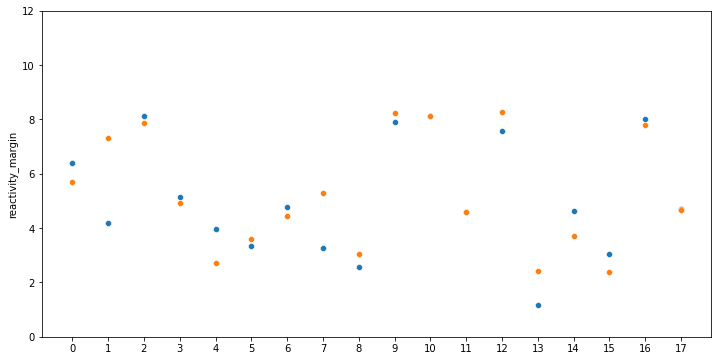

In [173]:
plt.rcParams['figure.figsize'] = (12,6)
y_pred = bst.predict(dtest)
ax = sns.scatterplot(x=range(len(y_pred)), y=y_pred)
sns.scatterplot(x=range(len(y_pred)), y=y_test3, ax=ax)
ax.set_xticks(range(len(y_pred)))
ax.set_ylim([0,12])

In [129]:
mean_squared_error(y_test3, y_pred, squared=False)

1.0545195775407747

# Вывод

По сравнению с моделями sklearn удалось **снизить** ошибку с **1.39** до **1.05**

# Opuna + Tensorflow

In [ ]:
EPOCHS = 200
train_x, valid_x, train_y, valid_y = train_test_split(X_train3, y_train3, test_size=0.2)



train_data = tf.convert_to_tensor(train_x)
train_y = train_y.astype('float32')
# train_label = tf.convert_to_tensor(train_y)
valid_data = tf.convert_to_tensor(valid_x)
valid_y = valid_y.astype('float32')
# valid_label = tf.convert_to_tensor(valid_y)

train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_y))
train_ds = train_ds.batch(train_data.shape[1])

valid_ds = tf.data.Dataset.from_tensor_slices((valid_data, valid_y))
valid_ds = valid_ds.batch(train_data.shape[1])

def create_model(trial):
    # We optimize the numbers of layers, their units and weight decay parameter.
    n_layers = trial.suggest_int("n_layers", 2, 4)
    weight_decay = trial.suggest_float("weight_decay", 1e-10, 1e-3, log=True)
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(481,)))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    for i in range(n_layers):
        num_hidden = trial.suggest_int("n_units_l{}".format(i), 4, 1024, log=True)
        model.add(
            tf.keras.layers.Dense(
                num_hidden,
                activation="relu",
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
            )
        )
    model.add(
        tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(weight_decay))
    )
    return model


def create_optimizer(trial):
    # We optimize the choice of optimizers as well as their parameters.
    kwargs = {}
    optimizer_options = ["RMSprop", "Adam", "SGD"]
    optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
    if optimizer_selected == "RMSprop":
        kwargs["learning_rate"] = trial.suggest_float(
            "rmsprop_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["decay"] = trial.suggest_float("rmsprop_decay", 0.85, 0.99)
        kwargs["momentum"] = trial.suggest_float("rmsprop_momentum", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "Adam":
        kwargs["learning_rate"] = trial.suggest_float("adam_learning_rate", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "SGD":
        kwargs["learning_rate"] = trial.suggest_float(
            "sgd_opt_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["momentum"] = trial.suggest_float("sgd_opt_momentum", 1e-5, 1e-1, log=True)

    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer


def learn(model, optimizer, dataset, mode="eval"):
    rmse = tf.keras.metrics.RootMeanSquaredError('rmse', dtype=tf.float32)

    for data, labels in dataset:
        with tf.GradientTape() as tape:
            logits = model(data, training=(mode == "train"))
            logits = tf.reshape(logits, -1)
            loss_value = tf.keras.losses.MeanSquaredError()(logits, labels)
            if mode == "eval":
                rmse(logits, labels)
            else:
                grads = tape.gradient(loss_value, model.variables)
                optimizer.apply_gradients(zip(grads, model.variables))

    if mode == "eval":
        return rmse


    
def objective(trial, data=data, label=label):

    # Build model and optimizer.
    model = create_model(trial)
    optimizer = create_optimizer(trial)

    # Training and validating cycle.
    with tf.device("/cpu:0"):
        for _ in range(EPOCHS):
            learn(model, optimizer, train_ds, "train")

        rmse = learn(model, optimizer, valid_ds, "eval")
    return rmse.result()


if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=100)

    print("Number of finished trials: ", len(study.trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-07-12 16:53:26,222] A new study created in memory with name: no-name-36d603f1-e688-4ac6-9857-c651d8c18026
[I 2022-07-12 16:53:29,293] Trial 0 finished with value: 2.073219060897827 and parameters: {'n_layers': 4, 'weight_decay': 0.0005590608162111551, 'n_units_l0': 145, 'n_units_l1': 337, 'n_units_l2': 86, 'n_units_l3': 15, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.04518543498176101, 'rmsprop_decay': 0.953802594715362, 'rmsprop_momentum': 0.006018304185107634}. Best is trial 0 with value: 2.073219060897827.
[I 2022-07-12 16:53:32,070] Trial 1 finished with value: 5.287815093994141 and parameters: {'n_layers': 2, 'weight_decay': 5.892230165885763e-10, 'n_units_l0': 784, 'n_units_l1': 30, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 6.807697853791677e-05, 'rmsprop_decay': 0.946469076850421, 'rmsprop_momentum': 0.00020103609384812012}. Best is trial 0 with value: 2.073219060897827.
[I 2022-07-12 16:53:34,559] Trial 2 finished with value: 2.098905086517334 and paramete

In [294]:
tf.keras.losses.MeanSquaredError()(np.array([1,2,3]), np.array([4,5,6]))

<tf.Tensor: shape=(), dtype=int32, numpy=9>

In [245]:
(x_train, y_train), (x_valid, y_valid) = mnist.load_data()
x_train = x_train.astype("float32") / 255
y_train = y_train.astype("int32")


train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(60000).batch(BATCHSIZE)#.take(N_TRAIN_EXAMPLES)


In [244]:
train_ds

<TensorSliceDataset element_spec=(TensorSpec(shape=(28, 28), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [246]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [232]:
n_layers = 3
weight_decay = 0.01
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(481, )))
model.add(tf.keras.layers.Dense(256, input_shape=(481, ), activation='relu'))
for i in range(n_layers):
    num_hidden = 512
    model.add(
        tf.keras.layers.Dense(
            num_hidden,
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
        )
    )
model.add(
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(weight_decay))
)
model.summary()

Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_266 (Dense)           (None, 256)               123392    
                                                                 
 dense_267 (Dense)           (None, 512)               131584    
                                                                 
 dense_268 (Dense)           (None, 512)               262656    
                                                                 
 dense_269 (Dense)           (None, 512)               262656    
                                                                 
 dense_270 (Dense)           (None, 1)                 513       
                                                                 
Total params: 780,801
Trainable params: 780,801
Non-trainable params: 0
_________________________________________________________________
